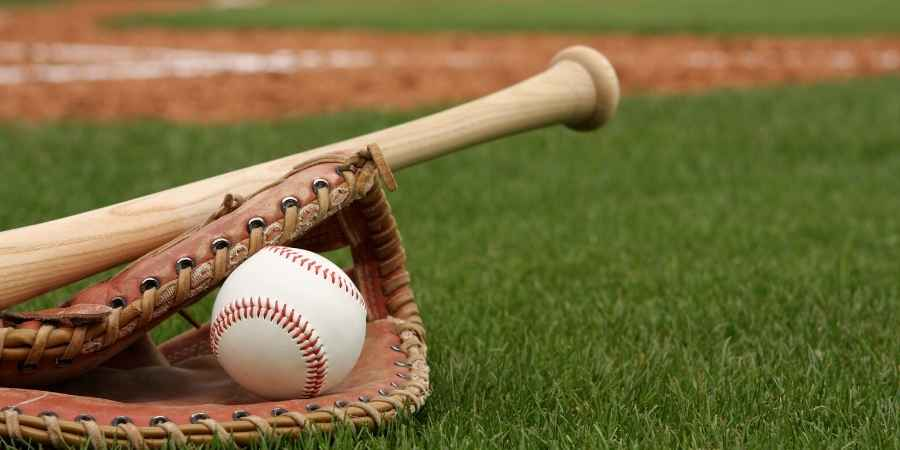

# Predicting MLB Free Agent Salaries
---

## Author
---
Jordan Kominsky

Data Scientist

[LinkedIn](https://www.linkedin.com/in/jordan-kominsky/) | 
[GitHub](https://github.com/jskominsky) | 
[Email](mailto:jskominsky@gmail.com)

# Business Understanding
---

Every year in Major League Baseball (MLB), hundreds of players become free agents.  During this time, their agents are consistently meeting with both their clients (players) and the general managers who they are negotiating these contracts with.  Sometimes, players can avoid free agency altogether by signing a contract extension with their current team prior to their contract expiring.  

Over the past few years, there have been situations where players have too high of expectations for the contract they will receive, due to bad advice and overly optimistic thinking by their agents.  In March of 2021, the New York Mets reportedly offered their outfielder Michael Conforto, a 5 or 6 year contract worth \\$100-120 million.  He declined this contract after consulting with his agent, Scott Boras.  A year later Michael Conforto remains unsigned 2 months into the 2022 MLB season and has undergone season ending surgery on his shoulder, meaning he will earn \\$0 this season.  During the offseason before the 2018 season, infielder Mike Moustakas was offered a qualifying offer, which was a one year contract worth \\$17.4 million.  After consulting with his agent, Scott Boras, he declined this offer seeking a multi year deal.  Moustakas ended up signing a one year, \\$6.5 million contract that offseason.  The next offseason, he signed a one year, \\$10 million contract.  If he had been given proper advice, he would have made more money in the 2018 season than he ended up making in the 2018 and 2019 seasons combined.  

Agents not having realistic expectations and not understanding what their clients will be offered by general managers, puts them at a competitive disadvantage.  It can make their clients upset, and can lead to being fired, when the players don't receive the contract offers they were told by their agent to expect.  It also puts agents at a competitive disadvantage in negotiations with general managers.

# Overview
---

I was hired by the Boras Corporation to create a predictive model to better predict MLB free agent hitters salaries.  After these major blunders with Michael Conforto and Mike Moustakas's contracts, the Boras Corparation has realized that they need to be able to better predict free agent salaries so they can tell their clients what to expect, and to give them a leg up in negotiations with MLB general managers.

In order to address the problem that the Boras Corporation is facing, I will use the following regression models to improve the companies ability to predict free agent salaries:

1. Random Forest Regression
2. XGBoost Regressor
3. XGBoost Random Forest (XGBRF) Regressor

I chose to use these models because they all can handle multicollinearity and have the ability to tell me feature importance.  Feature importance is important because the agents can tell their clients what part of their game to improve during the offseason to give them the best chance at a bigger contract. 

# Data Understanding
---

My original dataset was found at [Kaggle.com](https://www.kaggle.com/datasets/open-source-sports/baseball-databank).  The dataset contained 20 CSV files that included MLB data from 1871-2021. Of those 20 CSV's I used the following: 
- AllstarFull.csv
- AwardsPlayes.csv
- AwardsSharePlayers.csv
- Batting.csv
- People.csv
- Salaries.csv
- Teams.csv

While the batting.csv statistics went through 2021, the salaries only went through 2016, so I wanted to find data for the salaries from 2017-2021.  I found this data at [Cot's Baseball Contracts](https://legacy.baseballprospectus.com/compensation/cots/). This data included salary data from 2000-2021, and helped me fill in 1600 values in the original salary data that were null. While searching for more salary data to fill in the null values, I found data at [The Baseball Cube](https://www.thebaseballcube.com/content/store/). This data included salary data from 1985-2022. I purchased this data set for $20. It helped me fill in 6,449 null values in the original salary data.

I subsetted my data to only use data from 1984-2021.  I also subsetted my data to only include players who played at least 6 seasons (so the only players included were ones who played long enough to make it to free agency).  I then made a new dataframe where the columns of the dataframe were the players' hitting statistics for each of his first 6 seasons, and included the players' average salary of his 7th, 8th, 9th, and 10th seasons (or less if he didn't play 10 seasons). This created a dataframe that was 1063 rows (one for each player in my dataset that played 6 or more seasons) by 131 columns.  The columns included the players' hitting statistics for his first 6 seasons, along with whether he made the All Star Game, whether he started the All Star Game, whether he won an award, or got votes for MVP or Rookie of the Year,  whether his team made the playoffs, and if his team won the World Series.

## Imports

In [2]:
import pandas as pd 
pd.set_option('display.max_columns', None)
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.dummy import DummyClassifier
import xgboost
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading in Data

In [3]:
allstar_df = pd.read_csv("../data/AllstarFull.csv")

In [4]:
awards1_df = pd.read_csv("../data/AwardsPlayers.csv")

In [5]:
awards2_df = pd.read_csv("../data/AwardsSharePlayers.csv")

In [6]:
batting_df = pd.read_csv("../data/Batting.csv")

In [7]:
people_df = pd.read_csv("../data/People.csv")

In [8]:
salaries_df = pd.read_csv("../data/Salaries.csv")

In [9]:
salary2_df = pd.read_csv("../data/Salary2.csv", encoding='iso-8859-1')

Found the salary2_df data at [Cot's Baseball Contracts](https://legacy.baseballprospectus.com/compensation/cots/). This data included salary data from 2000-2021, and helped me fill in 1600 values in the original salary column that were null.

In [10]:
salary3_df = pd.read_csv("../data/salary_history.csv", encoding='iso-8859-1')

Found the salary3_df data at [The Baseball Cube](https://www.thebaseballcube.com/content/store).  This data included salary data from 1985-2022.  I purchased this data set for $20.  It helped me fill in 6,449 null values in the original salary column.

In [11]:
teams_df = pd.read_csv("../data/Teams.csv")

## Data Exploration

### Cleaning batting_df

In [12]:
batting_df.tail(10)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
110485,zavalse01,2021,1,CHA,AL,37,93,15,17,3,0,5,15.0,0.0,0.0,6,41.0,0.0,1.0,4.0,0.0,1.0
110486,zerpaan01,2021,1,KCA,AL,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
110487,zeuchtj01,2021,1,TOR,AL,5,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
110488,zimmebr01,2021,1,CLE,AL,99,299,44,68,9,1,8,35.0,15.0,3.0,30,122.0,0.0,15.0,0.0,4.0,3.0
110489,zimmebr02,2021,1,BAL,AL,14,4,0,0,0,0,0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0,0.0
110490,zimmejo02,2021,1,MIL,NL,2,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
110491,zimmeky01,2021,1,KCA,AL,52,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
110492,zimmery01,2021,1,WAS,NL,110,255,27,62,16,0,14,46.0,0.0,0.0,16,77.0,0.0,0.0,0.0,2.0,9.0
110493,zuberty01,2021,1,KCA,AL,31,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
110494,zuninmi01,2021,1,TBA,AL,109,333,64,72,11,2,33,62.0,0.0,0.0,34,132.0,0.0,7.0,0.0,1.0,7.0


In [13]:
batting_df.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP'],
      dtype='object')

Need to add columns for Batting Average (AVG), On Base Percentage (OBP), Slugging Percentage (SLG), On Base + Slugging (OPS), Strikeout percentage, and walk percentage

Can drop H, 2B, 3B, BB, SO, after creating the new columns.

Also want to drop HBP, SH, SF, GIDP, CS, IBB

In [14]:
#Creating a Plate Appearances column
batting_df['PA'] = (batting_df['AB'] + batting_df['HBP'] + batting_df['BB'] + batting_df['SF'] + batting_df['SH'] + batting_df['IBB'])

In [15]:
#Creating a Batting Average column
batting_df['AVG'] = batting_df['H'] / batting_df['AB']

In [16]:
#Creating an On Base Percentage column
batting_df['OBP'] = (batting_df['H'] + batting_df['BB'] + batting_df ['HBP']) / batting_df['PA']

In [17]:
#Creating a Slugging Percentage column
batting_df['SLG'] = ((batting_df['H'] - batting_df['2B'] - batting_df['3B'] - batting_df['HR']) + (2 * batting_df['2B']) + (3 * batting_df['3B'] + (4 * batting_df['HR']))) / batting_df['AB']

In [18]:
#Creating an On Base Plus Slugging Percentage column
batting_df['OPS'] = batting_df['OBP'] + batting_df['SLG']

In [19]:
#Creating a Strikeout Percentage column
batting_df['K%'] = 100 * (batting_df['SO'] / batting_df['PA'])

In [20]:
#Creating a Walk Percentage column
batting_df['BB%'] = 100 * ((batting_df['BB'] + batting_df['IBB']) / batting_df['PA'])

In [21]:
#Creating a Stolen Base Percentage column
batting_df['SB%'] = 100 * (batting_df['SB'] / (batting_df['SB'] + batting_df['CS'] ))

In [22]:
batting_df.tail()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,PA,AVG,OBP,SLG,OPS,K%,BB%,SB%
110490,zimmejo02,2021,1,MIL,NL,2,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN
110491,zimmeky01,2021,1,KCA,AL,52,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110492,zimmery01,2021,1,WAS,NL,110,255,27,62,16,0,14,46.0,0.0,0.0,16,77.0,0.0,0.0,0.0,2.0,9.0,273.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,NaN
110493,zuberty01,2021,1,KCA,AL,31,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN
110494,zuninmi01,2021,1,TBA,AL,109,333,64,72,11,2,33,62.0,0.0,0.0,34,132.0,0.0,7.0,0.0,1.0,7.0,375.0,0.216216,0.301333,0.558559,0.859892,35.200000,9.066667,NaN


In [23]:
batting_df['stint'].value_counts(normalize=True)

1    0.924911
2    0.070872
3    0.003937
4    0.000244
5    0.000036
Name: stint, dtype: float64

I can drop stint, I don't know what this column means (maybe how many times they were sent down to the minor leagues and came back up to MLB? However with 92.5% of the data being 1's I feel safe dropping this column.  

In [24]:
batting_df_clean = batting_df.drop(['stint', 'PA','H', '2B', '3B', 'BB', 'SO', 'HBP', 'SH', 'SF', 'GIDP', 'IBB', 'CS'], axis=1) 

In [25]:
batting_df_clean.tail(10)

,playerID,yearID,teamID,lgID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%
110485,zavalse01,2021,CHA,AL,37,93,15,5,15.0,0.0,0.182796,0.230769,0.376344,0.607113,39.423077,5.769231,NaN
110486,zerpaan01,2021,KCA,AL,1,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110487,zeuchtj01,2021,TOR,AL,5,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110488,zimmebr01,2021,CLE,AL,99,299,44,8,35.0,15.0,0.227425,0.324713,0.344482,0.669194,35.057471,8.620690,83.333333
110489,zimmebr02,2021,BAL,AL,14,4,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000,NaN
110490,zimmejo02,2021,MIL,NL,2,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN
110491,zimmeky01,2021,KCA,AL,52,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110492,zimmery01,2021,WAS,NL,110,255,27,14,46.0,0.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,NaN
110493,zuberty01,2021,KCA,AL,31,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN
110494,zuninmi01,2021,TBA,AL,109,333,64,33,62.0,0.0,0.216216,0.301333,0.558559,0.859892,35.200000,9.066667,NaN


### Cleaning people_df

In [26]:
people_df.tail(10)

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
20360,zuberty01,1995.0,6.0,16.0,USA,AR,White Hall,NaN,NaN,NaN,NaN,NaN,NaN,Tyler,Zuber,John Tyler,175.0,71.0,R,R,2020-07-24,2021-09-30,zubet001,zuberty01
20361,zuletju01,1975.0,3.0,28.0,Panama,Panama,Panama,NaN,NaN,NaN,NaN,NaN,NaN,Julio,Zuleta,Julio Ernesto,230.0,78.0,R,R,2000-04-06,2001-06-25,zulej001,zuletju01
20362,zumayjo01,1984.0,11.0,9.0,USA,CA,Chula Vista,NaN,NaN,NaN,NaN,NaN,NaN,Joel,Zumaya,Joel Martin,215.0,75.0,R,R,2006-04-03,2010-06-28,zumaj001,zumayjo01
20363,zuninmi01,1991.0,3.0,25.0,USA,FL,Cape Coral,NaN,NaN,NaN,NaN,NaN,NaN,Mike,Zunino,Michael Accorsi,235.0,74.0,R,R,2013-06-12,2021-10-03,zunim001,zuninmi01
20364,zupcibo01,1966.0,8.0,18.0,USA,PA,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,Bob,Zupcic,Robert,220.0,76.0,R,R,1991-09-07,1994-08-04,zupcb001,zupcibo01
20365,zupofr01,1939.0,8.0,29.0,USA,CA,San Francisco,2005.0,3.0,25.0,USA,CA,Burlingame,Frank,Zupo,Frank Joseph,182.0,71.0,L,R,1957-07-01,1961-05-09,zupof101,zupofr01
20366,zuvelpa01,1958.0,10.0,31.0,USA,CA,San Mateo,NaN,NaN,NaN,NaN,NaN,NaN,Paul,Zuvella,Paul,173.0,72.0,R,R,1982-09-04,1991-05-02,zuvep001,zuvelpa01
20367,zuverge01,1924.0,8.0,20.0,USA,MI,Holland,2014.0,9.0,8.0,USA,AZ,Tempe,George,Zuverink,George,195.0,76.0,R,R,1951-04-21,1959-06-15,zuveg101,zuverge01
20368,zwilldu01,1888.0,11.0,2.0,USA,MO,St. Louis,1978.0,3.0,27.0,USA,CA,La Crescenta,Dutch,Zwilling,Edward Harrison,160.0,66.0,L,L,1910-08-14,1916-07-12,zwild101,zwilldu01
20369,zychto01,1990.0,8.0,7.0,USA,IL,Monee,NaN,NaN,NaN,NaN,NaN,NaN,Tony,Zych,Anthony Aaron,190.0,75.0,R,R,2015-09-04,2017-08-19,zycht001,zychto01


In [27]:
people_df.columns

Index(['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame',
       'retroID', 'bbrefID'],
      dtype='object')

Can drop birth country, birth state, birth city, death year, death month, death day, death country, death state, death city, final game.

Need to do more research to see which id is used, I see playedID, retroID, and bbredID.  At first glance it seems like playerID and bbrefID are the same. Not sure if retroID is used for anything.

In [28]:
people_df.drop(['birthCountry','birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay','deathCountry', 'deathState', 'deathCity', 'finalGame'], axis=1, inplace=True) 

In [29]:
people_df.tail(10)

,playerID,birthYear,birthMonth,birthDay,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,retroID,bbrefID
20360,zuberty01,1995.0,6.0,16.0,Tyler,Zuber,John Tyler,175.0,71.0,R,R,2020-07-24,zubet001,zuberty01
20361,zuletju01,1975.0,3.0,28.0,Julio,Zuleta,Julio Ernesto,230.0,78.0,R,R,2000-04-06,zulej001,zuletju01
20362,zumayjo01,1984.0,11.0,9.0,Joel,Zumaya,Joel Martin,215.0,75.0,R,R,2006-04-03,zumaj001,zumayjo01
20363,zuninmi01,1991.0,3.0,25.0,Mike,Zunino,Michael Accorsi,235.0,74.0,R,R,2013-06-12,zunim001,zuninmi01
20364,zupcibo01,1966.0,8.0,18.0,Bob,Zupcic,Robert,220.0,76.0,R,R,1991-09-07,zupcb001,zupcibo01
20365,zupofr01,1939.0,8.0,29.0,Frank,Zupo,Frank Joseph,182.0,71.0,L,R,1957-07-01,zupof101,zupofr01
20366,zuvelpa01,1958.0,10.0,31.0,Paul,Zuvella,Paul,173.0,72.0,R,R,1982-09-04,zuvep001,zuvelpa01
20367,zuverge01,1924.0,8.0,20.0,George,Zuverink,George,195.0,76.0,R,R,1951-04-21,zuveg101,zuverge01
20368,zwilldu01,1888.0,11.0,2.0,Dutch,Zwilling,Edward Harrison,160.0,66.0,L,L,1910-08-14,zwild101,zwilldu01
20369,zychto01,1990.0,8.0,7.0,Tony,Zych,Anthony Aaron,190.0,75.0,R,R,2015-09-04,zycht001,zychto01


I am dropping birthMonth and birthDay because I am going to pull the year from debut and subtract it from birthYear to have debut age, and then will drop debut and birthYear.

Also dropping nameGiven because it is redundant.

In [30]:
people_df.drop(['birthMonth' , 'birthDay' , 'nameGiven'], axis=1, inplace=True)

In [31]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20370 entries, 0 to 20369
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   playerID   20370 non-null  object 
 1   birthYear  20259 non-null  float64
 2   nameFirst  20333 non-null  object 
 3   nameLast   20370 non-null  object 
 4   weight     19554 non-null  float64
 5   height     19634 non-null  float64
 6   bats       19189 non-null  object 
 7   throws     19393 non-null  object 
 8   debut      20160 non-null  object 
 9   retroID    20321 non-null  object 
 10  bbrefID    20357 non-null  object 
dtypes: float64(3), object(8)
memory usage: 1.7+ MB


Creating a new column called debut age, and then will drop debut and birthYear.

In [32]:
people_df['DebutAge'] = pd.to_datetime(people_df['debut']).dt.year - people_df['birthYear']

In [33]:
people_df.tail()

,playerID,birthYear,nameFirst,nameLast,weight,height,bats,throws,debut,retroID,bbrefID,DebutAge
20365,zupofr01,1939.0,Frank,Zupo,182.0,71.0,L,R,1957-07-01,zupof101,zupofr01,18.0
20366,zuvelpa01,1958.0,Paul,Zuvella,173.0,72.0,R,R,1982-09-04,zuvep001,zuvelpa01,24.0
20367,zuverge01,1924.0,George,Zuverink,195.0,76.0,R,R,1951-04-21,zuveg101,zuverge01,27.0
20368,zwilldu01,1888.0,Dutch,Zwilling,160.0,66.0,L,L,1910-08-14,zwild101,zwilldu01,22.0
20369,zychto01,1990.0,Tony,Zych,190.0,75.0,R,R,2015-09-04,zycht001,zychto01,25.0


In [34]:
people_df.drop(['debut' , 'birthYear'], axis=1, inplace=True)

In [35]:
people_df.tail(10) 

,playerID,nameFirst,nameLast,weight,height,bats,throws,retroID,bbrefID,DebutAge
20360,zuberty01,Tyler,Zuber,175.0,71.0,R,R,zubet001,zuberty01,25.0
20361,zuletju01,Julio,Zuleta,230.0,78.0,R,R,zulej001,zuletju01,25.0
20362,zumayjo01,Joel,Zumaya,215.0,75.0,R,R,zumaj001,zumayjo01,22.0
20363,zuninmi01,Mike,Zunino,235.0,74.0,R,R,zunim001,zuninmi01,22.0
20364,zupcibo01,Bob,Zupcic,220.0,76.0,R,R,zupcb001,zupcibo01,25.0
20365,zupofr01,Frank,Zupo,182.0,71.0,L,R,zupof101,zupofr01,18.0
20366,zuvelpa01,Paul,Zuvella,173.0,72.0,R,R,zuvep001,zuvelpa01,24.0
20367,zuverge01,George,Zuverink,195.0,76.0,R,R,zuveg101,zuverge01,27.0
20368,zwilldu01,Dutch,Zwilling,160.0,66.0,L,L,zwild101,zwilldu01,22.0
20369,zychto01,Tony,Zych,190.0,75.0,R,R,zycht001,zychto01,25.0


In [36]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20370 entries, 0 to 20369
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   playerID   20370 non-null  object 
 1   nameFirst  20333 non-null  object 
 2   nameLast   20370 non-null  object 
 3   weight     19554 non-null  float64
 4   height     19634 non-null  float64
 5   bats       19189 non-null  object 
 6   throws     19393 non-null  object 
 7   retroID    20321 non-null  object 
 8   bbrefID    20357 non-null  object 
 9   DebutAge   20051 non-null  float64
dtypes: float64(3), object(7)
memory usage: 1.6+ MB


In [37]:
(people_df['playerID'] == people_df['bbrefID']).sum()

20123

In [38]:
20123/20370

0.9878743249877271

98.8% of our playerID coulumn is a match to our bbrefID column.  Don't need this column and will be dropping it.

In [39]:
(people_df['playerID'] == people_df['retroID']).sum()

0

playerID and retroID have no rows in which they are equal.  Don't need retroID and will be dropping it.

In [40]:
people_df.drop(['bbrefID' , 'retroID'], axis=1, inplace=True)

Creating a new column called full_name and then dropping the nameFirst and nameLast columns.

In [41]:
people_df['full_name'] = (people_df['nameFirst'] + ' ' + people_df['nameLast'])

In [42]:
people_df.drop(['nameFirst' , 'nameLast'], axis=1, inplace=True)

In [43]:
people_df_clean = people_df

In [44]:
people_df.drop(['weight' , 'height' , 'bats' , 'throws'], axis=1, inplace=True)

In [45]:
people_df_clean.tail()

,playerID,DebutAge,full_name
20365,zupofr01,18.0,Frank Zupo
20366,zuvelpa01,24.0,Paul Zuvella
20367,zuverge01,27.0,George Zuverink
20368,zwilldu01,22.0,Dutch Zwilling
20369,zychto01,25.0,Tony Zych


### Cleaning allstar_df

In [46]:
allstar_df.tail(10)

,playerID,yearID,gameNum,gameID,teamID,lgID,GP,startingPos
5444,reyesal02,2021,0,NLS202107130,SLN,NL,0,NaN
5445,rogertr01,2021,0,NLS202107130,MIA,NL,1,NaN
5446,schwaky01,2021,0,NLS202107130,WAS,NL,0,NaN
5447,sotoju01,2021,0,NLS202107130,WAS,NL,1,NaN
5448,tayloch03,2021,0,NLS202107130,LAN,NL,1,NaN
5449,turneju01,2021,0,NLS202107130,LAN,NL,1,NaN
5450,turnetr01,2021,0,NLS202107130,WAS,NL,1,NaN
5451,walketa01,2021,0,NLS202107130,NYN,NL,1,NaN
5452,wheelza01,2021,0,NLS202107130,PHI,NL,0,NaN
5453,woodrbr01,2021,0,NLS202107130,MIL,NL,0,NaN


In [47]:
allstar_df.columns

Index(['playerID', 'yearID', 'gameNum', 'gameID', 'teamID', 'lgID', 'GP',
       'startingPos'],
      dtype='object')

In [48]:
allstar_df['gameNum'].value_counts(normalize=True)

0    0.937110
2    0.033187
1    0.029703
Name: gameNum, dtype: float64

Can drop gameNum column because since I am only going to use data from 1990-present.  There hasn't been more than 1 All Star Game since 1962.

In [49]:
#Dropping the gameNum column
allstar_df.drop(['gameNum'], axis=1, inplace=True) 

In [50]:
allstar_df['startingPos'].value_counts(normalize=True)

8.0     0.108708
7.0     0.108708
6.0     0.108708
5.0     0.108708
4.0     0.108708
3.0     0.108708
2.0     0.108708
9.0     0.108124
1.0     0.106371
10.0    0.024547
Name: startingPos, dtype: float64

Wanted to make sure that the values in startingPos made sense, and they do. However, since I don't care what postion they started at, just they they did in fact start, I will convert those to 1's or 0's for whether or not this player started the all star game that year.

In [51]:
allstar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5454 entries, 0 to 5453
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   playerID     5454 non-null   object 
 1   yearID       5454 non-null   int64  
 2   gameID       5405 non-null   object 
 3   teamID       5454 non-null   object 
 4   lgID         5454 non-null   object 
 5   GP           5454 non-null   int64  
 6   startingPos  1711 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 298.4+ KB


startingPos will be a good way to see if a player started in an all star game or if they came off the bench (the NaN values).

In [52]:
allstar_df['GP'].value_counts(normalize=True)

1    0.779611
0    0.220389
Name: GP, dtype: float64

Whether or not someone actually played in the All Star Game isn't important, what's important is that they were on voted to make the team.  I feel safe dropping GP.

In [53]:
#Dropping the Game Played column
allstar_df.drop(['GP'], axis=1, inplace=True) 

In [54]:
allstar_df.tail()

,playerID,yearID,gameID,teamID,lgID,startingPos
5449,turneju01,2021,NLS202107130,LAN,NL,NaN
5450,turnetr01,2021,NLS202107130,WAS,NL,NaN
5451,walketa01,2021,NLS202107130,NYN,NL,NaN
5452,wheelza01,2021,NLS202107130,PHI,NL,NaN
5453,woodrbr01,2021,NLS202107130,MIL,NL,NaN


I am dropping gameID, teamID, and lgID because this data is either not neeeded or will will be found in other dataframes this will be merged on.

In [55]:
allstar_df.drop(['gameID','teamID','lgID'], axis=1, inplace=True)

In [56]:
allstar_df_clean = allstar_df

In [57]:
allstar_df_clean.tail(50)

,playerID,yearID,startingPos
5404,pressry01,2021,NaN
5405,ramirjo01,2021,NaN
5406,rodonca01,2021,NaN
5407,rogerta01,2021,NaN
5408,sotogr01,2021,NaN
5409,troutmi01,2021,NaN
5410,walshja01,2021,NaN
5411,wendljo01,2021,NaN
5412,zuninmi01,2021,NaN
5413,scherma01,2021,1.0


Ran a tail(50) to make sure that the startingPos column was working properly and it is.  Going to create a new column for whether or not the player is an all star or not.  Everyone on this list should have a 1 for the column allstar because they are all allstars.

In [58]:
allstar_df_clean['allstar'] = allstar_df_clean['startingPos'].isna()

In [59]:
allstar_df_clean

,playerID,yearID,startingPos,allstar
0,gomezle01,1933,1.0,False
1,ferreri01,1933,2.0,False
2,gehrilo01,1933,3.0,False
3,gehrich01,1933,4.0,False
4,dykesji01,1933,5.0,False
...,...,...,...,...
5449,turneju01,2021,NaN,True
5450,turnetr01,2021,NaN,True
5451,walketa01,2021,NaN,True
5452,wheelza01,2021,NaN,True


In [60]:
allstar_df_clean['allstar'] = allstar_df_clean['allstar'].astype(int)

In [61]:
allstar_df_clean

,playerID,yearID,startingPos,allstar
0,gomezle01,1933,1.0,0
1,ferreri01,1933,2.0,0
2,gehrilo01,1933,3.0,0
3,gehrich01,1933,4.0,0
4,dykesji01,1933,5.0,0
...,...,...,...,...
5449,turneju01,2021,NaN,1
5450,turnetr01,2021,NaN,1
5451,walketa01,2021,NaN,1
5452,wheelza01,2021,NaN,1


Now I'm going to replace the 0's in the column allstar with 1's because, as I mentioned above, everyone in this list was voted as an allstar, so should have 1's for the allstar column.

In [62]:
allstar_df_clean['allstar'].replace(0 , 1 , inplace=True)

Since I don't care about the position that someone started at, just that they started the all star game, I am going to create a column for allstar_starter and make it so that starters have a 1 and bench players have a 0.

In [63]:
allstar_df_clean['allstar_starter'] = allstar_df_clean['startingPos'].isna()

In [64]:
allstar_df_clean['allstar_starter'] = allstar_df_clean['allstar_starter'].map({False : 1 , True : 0})

In [65]:
allstar_df_clean.drop(['startingPos'], axis=1, inplace=True)

In [66]:
allstar_df_clean

,playerID,yearID,allstar,allstar_starter
0,gomezle01,1933,1,1
1,ferreri01,1933,1,1
2,gehrilo01,1933,1,1
3,gehrich01,1933,1,1
4,dykesji01,1933,1,1
...,...,...,...,...
5449,turneju01,2021,1,0
5450,turnetr01,2021,1,0
5451,walketa01,2021,1,0
5452,wheelza01,2021,1,0


### Cleaning awards1_df

In [67]:
awards1_df.tail(10)

,playerID,awardID,yearID,lgID,tie,notes
6521,albieoz01,TSN All-Star,2021,NL,NaN,2B
6522,machama01,TSN All-Star,2021,NL,NaN,3B
6523,tatisfe02,TSN All-Star,2021,NL,NaN,SS
6524,sotoju01,TSN All-Star,2021,NL,NaN,OF
6525,harpebr03,TSN All-Star,2021,NL,NaN,OF
6526,reynobr01,TSN All-Star,2021,NL,NaN,OF
6527,scherma01,TSN All-Star,2021,NL,NaN,SP
6528,haderjo01,TSN All-Star,2021,NL,NaN,RP
6529,friedma01,Silver Slugger,2021,NL,NaN,P
6530,ramirjo01,TSN All-Star,2021,AL,NaN,3B


In [68]:
awards1_df.columns

Index(['playerID', 'awardID', 'yearID', 'lgID', 'tie', 'notes'], dtype='object')

In [69]:
awards1_df['awardID'].value_counts()

Baseball Magazine All-Star             1520
TSN All-Star                           1477
Gold Glove                             1164
Silver Slugger                          752
Most Valuable Player                    204
Rookie of the Year                      150
TSN Pitcher of the Year                 137
Cy Young Award                          122
TSN Player of the Year                   92
TSN Fireman of the Year                  88
TSN Major League Player of the Year      82
Rolaids Relief Man Award                 74
World Series MVP                         69
Babe Ruth Award                          64
Lou Gehrig Memorial Award                57
All-Star Game MVP                        55
Roberto Clemente Award                   52
Hutch Award                              48
NLCS MVP                                 47
Hank Aaron Award                         46
ALCS MVP                                 41
Pitching Triple Crown                    38
TSN Guide MVP                   

Dropping awardID, lgID, tie, notes because I just want to use this data to know whether or not they player won an award, I don't care what the award was (since I have a column that covers Rookie of the Year and MVP voting I will use that for the big awards), the league, if they tied, or their position. 

In [70]:
awards1_df_clean = awards1_df.drop(['awardID', 'lgID', 'tie' , 'notes'], axis=1)

In [71]:
awards1_df_clean

,playerID,yearID
0,bondto01,1877
1,hinespa01,1878
2,heckegu01,1884
3,radboch01,1884
4,oneilti01,1887
...,...,...
6526,reynobr01,2021
6527,scherma01,2021
6528,haderjo01,2021
6529,friedma01,2021


Similar to what I did above in allstar_df, I am going to make the column won_award and make this a binary column of 1 for won award and 0 for didn't.  Obviously everyone in awards1_df_clean has won an award, the 0's will be when I merge on my batting dataframe with the hitting statistics.

In [72]:
awards1_df_clean['won_award'] = awards1_df_clean['yearID'].isna()

In [73]:
awards1_df_clean['won_award'] = awards1_df_clean['won_award'].astype(int)

In [74]:
awards1_df_clean['won_award'] = awards1_df_clean['won_award'].map({False : 1 , True : 0})

In [75]:
awards1_df_clean

,playerID,yearID,won_award
0,bondto01,1877,1
1,hinespa01,1878,1
2,heckegu01,1884,1
3,radboch01,1884,1
4,oneilti01,1887,1
...,...,...,...
6526,reynobr01,2021,1
6527,scherma01,2021,1
6528,haderjo01,2021,1
6529,friedma01,2021,1


### Cleaning awards2_df

In [76]:
awards2_df.tail(10)

,awardID,yearID,lgID,playerID,pointsWon,pointsMax,votesFirst
6869,Rookie of the Year,2016,AL,mazarno01,4.0,150,0.0
6870,Rookie of the Year,2016,AL,anderti01,2.0,150,0.0
6871,Rookie of the Year,2016,NL,seageco01,150.0,150,30.0
6872,Rookie of the Year,2016,NL,turnetr01,42.0,150,0.0
6873,Rookie of the Year,2016,NL,maedake01,37.0,150,0.0
6874,Rookie of the Year,2016,NL,storytr01,24.0,150,0.0
6875,Rookie of the Year,2016,NL,diazal02,14.0,150,0.0
6876,Rookie of the Year,2016,NL,grayjo02,1.0,150,0.0
6877,Rookie of the Year,2016,NL,matzst01,1.0,150,0.0
6878,Rookie of the Year,2016,NL,ohse01,1.0,150,0.0


In [77]:
awards2_df.columns

Index(['awardID', 'yearID', 'lgID', 'playerID', 'pointsWon', 'pointsMax',
       'votesFirst'],
      dtype='object')

In [78]:
awards2_df['awardID'].value_counts()

MVP                   5263
Rookie of the Year     831
Cy Young               785
Name: awardID, dtype: int64

awards2_df includes the 2 biggest individual awards for hitters, MVP and Rookie of the Year.  I will use awards1_df to show if a player has won any type of award, I will use awards2_df to show if they received any votes for one of the 2 biggest awards in MLB. Will drop pointsMax, votesFirst, and lgID because I don't need these columns.

In [79]:
awards2_df_clean = awards2_df.drop(['pointsMax' , 'votesFirst', 'lgID'], axis=1)

In [80]:
awards2_df_clean.tail(10)

,awardID,yearID,playerID,pointsWon
6869,Rookie of the Year,2016,mazarno01,4.0
6870,Rookie of the Year,2016,anderti01,2.0
6871,Rookie of the Year,2016,seageco01,150.0
6872,Rookie of the Year,2016,turnetr01,42.0
6873,Rookie of the Year,2016,maedake01,37.0
6874,Rookie of the Year,2016,storytr01,24.0
6875,Rookie of the Year,2016,diazal02,14.0
6876,Rookie of the Year,2016,grayjo02,1.0
6877,Rookie of the Year,2016,matzst01,1.0
6878,Rookie of the Year,2016,ohse01,1.0


Using the pointsWon column to create a new column called award_votes.  This column will tell us whether or not a player received votes for MVP or Rookie of the Year.  Everyone in awards2_df_clean should have a 1 under the award_votes column. I can then drop the awardID and pointsWon columns.

In [81]:
awards2_df_clean['award_votes'] = awards2_df_clean['pointsWon'].isna()

In [82]:
awards2_df_clean['award_votes'] = awards2_df_clean['award_votes'].astype(int)

In [83]:
awards2_df_clean['award_votes'].replace(0 , 1 , inplace=True)

In [84]:
awards2_df_clean = awards2_df_clean.drop(['awardID' , 'pointsWon'], axis=1)

Dropping duplicates of players who got votes for both MVP and Rookie of the Year in the same season.

In [85]:
awards2_df_clean.drop_duplicates()

,yearID,playerID,award_votes
0,1956,fordwh01,1
1,1956,maglisa01,1
2,1956,newcodo01,1
3,1956,spahnwa01,1
4,1957,donovdi01,1
...,...,...,...
6874,2016,storytr01,1
6875,2016,diazal02,1
6876,2016,grayjo02,1
6877,2016,matzst01,1


### Cleaning salaries_df

In [86]:
salaries_df.tail(10)

,yearID,teamID,lgID,playerID,salary
26418,2016,WAS,NL,riverfe01,516100
26419,2016,WAS,NL,roarkta01,543400
26420,2016,WAS,NL,robincl01,534900
26421,2016,WAS,NL,rossjo01,514400
26422,2016,WAS,NL,scherma01,22142857
26423,2016,WAS,NL,strasst01,10400000
26424,2016,WAS,NL,taylomi02,524000
26425,2016,WAS,NL,treinbl01,524900
26426,2016,WAS,NL,werthja01,21733615
26427,2016,WAS,NL,zimmery01,14000000


In [87]:
salaries_df.shape

(26428, 5)

In [88]:
salaries_df_clean = salaries_df.drop(['teamID' , 'lgID'], axis=1)

In [89]:
salaries_df_clean.tail(10)

,yearID,playerID,salary
26418,2016,riverfe01,516100
26419,2016,roarkta01,543400
26420,2016,robincl01,534900
26421,2016,rossjo01,514400
26422,2016,scherma01,22142857
26423,2016,strasst01,10400000
26424,2016,taylomi02,524000
26425,2016,treinbl01,524900
26426,2016,werthja01,21733615
26427,2016,zimmery01,14000000


Creating a clean salaries dataframe that only includes players between 1984 and 2016 (which is the last year data is available from this data).

In [90]:
salaries_df_clean = salaries_df_clean[(salaries_df_clean['yearID']>= 1984) 
                                & (salaries_df_clean['yearID']<= 2016)]

In [91]:
salaries_df_clean['yearID'].value_counts()

1999    1006
1998     998
1995     986
1996     931
1997     925
1993     923
1994     884
1990     867
2001     860
2008     856
2016     853
2012     848
2002     846
2007     842
2011     839
2000     836
2005     831
2004     831
2010     830
2003     827
2006     819
2015     817
2013     815
2009     813
2014     802
1992     769
1986     738
1989     711
1991     685
1988     663
1987     627
1985     550
Name: yearID, dtype: int64

### Cleaning salary2_df

In [92]:
salary2_df

,full_name,salary2,yearID,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,Albert Belle,"$12,868,670",2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bernie Williams,"$12,357,143",2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Larry Walker,"$12,142,857",2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mike Piazza,"$12,071,429",2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mo Vaughn,"$11,166,667",2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9285,Chas McCormick,"$570,500",2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9286,Jose Rojas,"$570,500",2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9287,Ka'ai Tom,"$570,500",2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9288,Taylor Trammell,"$570,500",2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
salary2_df.columns

Index(['full_name', 'salary2', 'yearID', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24'],
      dtype='object')

In [94]:
salary2_df_clean = salary2_df.drop(['Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24'], axis=1)

In [95]:
salary2_df_clean

,full_name,salary2,yearID
0,Albert Belle,"$12,868,670",2000
1,Bernie Williams,"$12,357,143",2000
2,Larry Walker,"$12,142,857",2000
3,Mike Piazza,"$12,071,429",2000
4,Mo Vaughn,"$11,166,667",2000
...,...,...,...
9285,Chas McCormick,"$570,500",2021
9286,Jose Rojas,"$570,500",2021
9287,Ka'ai Tom,"$570,500",2021
9288,Taylor Trammell,"$570,500",2021


### Cleaning salary3_df

In [96]:
salary3_df

,firstname,lastname,full_name,yearID,salary
0,David,Aardsma,David Aardsma,2004,300000
1,David,Aardsma,David Aardsma,2006,327000
2,David,Aardsma,David Aardsma,2007,387500
3,David,Aardsma,David Aardsma,2008,403250
4,David,Aardsma,David Aardsma,2009,419000
...,...,...,...,...,...
45491,Paul,Zuvella,Paul Zuvella,1988,62500
45492,Paul,Zuvella,Paul Zuvella,1989,145000
45493,Tony,Zych,Tony Zych,2015,507500
45494,Tony,Zych,Tony Zych,2016,511000


In [97]:
salary3_df_clean = salary3_df.drop(['firstname', 'lastname'], axis=1)

In [98]:
salary3_df_clean

,full_name,yearID,salary
0,David Aardsma,2004,300000
1,David Aardsma,2006,327000
2,David Aardsma,2007,387500
3,David Aardsma,2008,403250
4,David Aardsma,2009,419000
...,...,...,...
45491,Paul Zuvella,1988,62500
45492,Paul Zuvella,1989,145000
45493,Tony Zych,2015,507500
45494,Tony Zych,2016,511000


### Cleaning teams_df

In [99]:
teams_df.tail(30)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
2955,2021,NL,ARI,ARI,W,5,162,81.0,52,110,N,N,N,N,679,5489,1297,308,31,144,537.0,1465.0,43.0,16.0,54.0,28.0,893,804,5.11,3,4,22,4252,1480,232,555,1238,100,113,0.983,Arizona Diamondbacks,Chase Field,1043010.0,99,101,ARI,ARI,ARI
2956,2021,NL,ATL,ATL,E,1,161,80.0,88,73,Y,N,Y,Y,790,5363,1307,269,20,239,549.0,1453.0,59.0,19.0,67.0,43.0,656,608,3.88,2,18,40,4232,1237,183,516,1417,71,104,0.988,Atlanta Braves,SunTrust Park,2300247.0,107,105,ATL,ATL,ATL
2957,2021,AL,BAL,BAL,E,5,162,81.0,52,110,N,N,N,N,659,5420,1296,266,15,195,451.0,1454.0,54.0,23.0,65.0,31.0,956,910,5.84,1,5,26,4206,1518,258,563,1234,74,101,0.987,Baltimore Orioles,Oriole Park at Camden Yards,793229.0,103,105,BAL,BAL,BAL
2958,2021,AL,BOS,BOS,E,2,162,81.0,92,70,N,Y,N,N,829,5495,1434,330,23,219,512.0,1386.0,40.0,21.0,61.0,42.0,749,671,4.26,0,7,49,4257,1409,176,546,1527,108,143,0.981,Boston Red Sox,Fenway Park II,1725323.0,109,109,BOS,BOS,BOS
2959,2021,AL,CHA,CHW,C,1,162,81.0,93,69,Y,N,N,N,796,5357,1373,275,22,190,586.0,1389.0,57.0,20.0,78.0,39.0,636,581,3.73,4,13,43,4210,1205,182,485,1588,97,112,0.982,Chicago White Sox,Guaranteed Rate Field,1596385.0,101,100,CHW,CHA,CHA
2960,2021,NL,CHN,CHC,C,4,162,81.0,71,91,N,N,N,N,705,5306,1255,225,26,210,502.0,1596.0,86.0,37.0,92.0,30.0,839,765,4.87,1,8,40,4238,1386,235,596,1358,87,149,0.985,Chicago Cubs,Wrigley Field,1978934.0,100,101,CHC,CHN,CHN
2961,2021,NL,CIN,CIN,C,3,162,81.0,83,79,N,N,N,N,786,5423,1352,295,13,222,553.0,1425.0,36.0,24.0,105.0,45.0,760,702,4.40,1,8,41,4303,1330,206,617,1524,91,124,0.984,Cincinnati Reds,Great American Ball Park,1505024.0,113,113,CIN,CIN,CIN
2962,2021,AL,CLE,CLE,C,2,162,81.0,80,82,N,N,N,N,717,5332,1269,248,22,203,453.0,1387.0,109.0,17.0,64.0,36.0,727,679,4.34,0,9,39,4224,1281,216,522,1391,86,138,0.985,Cleveland Indians,Progressive Field,1114368.0,101,101,CLE,CLE,CLE
2963,2021,NL,COL,COL,W,4,161,81.0,74,87,N,N,N,N,739,5374,1338,275,34,182,491.0,1356.0,76.0,23.0,58.0,36.0,796,748,4.82,3,6,33,4191,1397,196,539,1269,73,140,0.987,Colorado Rockies,Coors Field,1938645.0,112,113,COL,COL,COL
2964,2021,AL,DET,DET,C,3,162,81.0,77,85,N,N,N,N,697,5376,1299,236,37,179,490.0,1514.0,88.0,25.0,44.0,50.0,756,681,4.32,2,7,42,4259,1370,199,571,1259,83,136,0.986,Detroit Tigers,Comerica Park,1102621.0,96,98,DET,DET,DET


In [100]:
teams_df.columns

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome',
       'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR',
       'teamIDlahman45', 'teamIDretro'],
      dtype='object')

Can drop 'G', 'Ghome', 'R', 'AB', 'H', '2B','3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro'

I decided to use teams_df to pair to each player to designate whether or not that player was on a winning team.

In [101]:
teams_df_clean = teams_df.drop(['G', 'Ghome', 'R', 'AB', 'H', '2B','3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro'], axis=1)

In [102]:
teams_df_clean.tail(10)

,yearID,lgID,teamID,franchID,divID,Rank,W,L,DivWin,WCWin,LgWin,WSWin
2975,2021,NL,PHI,PHI,E,2,82,80,N,N,N,N
2976,2021,NL,PIT,PIT,C,5,61,101,N,N,N,N
2977,2021,NL,SDN,SDP,W,3,79,83,N,N,N,N
2978,2021,AL,SEA,SEA,W,2,90,72,N,N,N,N
2979,2021,NL,SFN,SFG,W,1,107,55,Y,N,N,N
2980,2021,NL,SLN,STL,C,2,90,72,N,Y,N,N
2981,2021,AL,TBA,TBD,E,1,100,62,Y,N,N,N
2982,2021,AL,TEX,TEX,W,5,60,102,N,N,N,N
2983,2021,AL,TOR,TOR,E,4,91,71,N,N,N,N
2984,2021,NL,WAS,WSN,E,5,65,97,N,N,N,N


Also need to drop 'franchID' , 'divID' , 'Rank' , 'W' , 'L' because I just want information on whether the team won the division, made the playoffs, made the World Series, or won the World Series.

In [103]:
teams_df_clean.drop(['franchID' , 'divID' , 'Rank' , 'W' , 'L'], axis=1, inplace=True)

In [104]:
teams_df_clean.tail()

,yearID,lgID,teamID,DivWin,WCWin,LgWin,WSWin
2980,2021,NL,SLN,N,Y,N,N
2981,2021,AL,TBA,Y,N,N,N
2982,2021,AL,TEX,N,N,N,N
2983,2021,AL,TOR,N,N,N,N
2984,2021,NL,WAS,N,N,N,N


### Merging Dataframes

In [105]:
# Merging batting_df_clean and people_df_clean
df_merged = batting_df_clean.merge(people_df_clean, how='left', on='playerID')

In [106]:
#Checking to make sure the merge was successful
df_merged.tail()

,playerID,yearID,teamID,lgID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name
110490,zimmejo02,2021,MIL,NL,2,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,23.0,Jordan Zimmermann
110491,zimmeky01,2021,KCA,AL,52,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,Kyle Zimmer
110492,zimmery01,2021,WAS,NL,110,255,27,14,46.0,0.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,NaN,21.0,Ryan Zimmerman
110493,zuberty01,2021,KCA,AL,31,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,25.0,Tyler Zuber
110494,zuninmi01,2021,TBA,AL,109,333,64,33,62.0,0.0,0.216216,0.301333,0.558559,0.859892,35.200000,9.066667,NaN,22.0,Mike Zunino


In [107]:
# Merging my new df_merged and allstar_df_clean
df_merged = df_merged.merge(allstar_df_clean, how='left', on=['playerID', 'yearID'])

In [108]:
#Checking to make sure the merge was successful
df_merged

,playerID,yearID,teamID,lgID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter
0,abercda01,1871,TRO,NaN,1,4,0,0,0.0,0.0,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,21.0,Frank Abercrombie,NaN,NaN
1,addybo01,1871,RC1,NaN,25,118,30,0,13.0,8.0,0.271186,NaN,0.322034,NaN,NaN,NaN,88.888889,29.0,Bob Addy,NaN,NaN
2,allisar01,1871,CL1,NaN,29,137,28,0,19.0,3.0,0.291971,NaN,0.394161,NaN,NaN,NaN,75.000000,22.0,Art Allison,NaN,NaN
3,allisdo01,1871,WS3,NaN,27,133,28,2,27.0,1.0,0.330827,NaN,0.481203,NaN,NaN,NaN,50.000000,25.0,Doug Allison,NaN,NaN
4,ansonca01,1871,RC1,NaN,25,120,29,0,16.0,6.0,0.325000,NaN,0.466667,NaN,NaN,NaN,75.000000,19.0,Cap Anson,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110704,zimmejo02,2021,MIL,NL,2,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,23.0,Jordan Zimmermann,NaN,NaN
110705,zimmeky01,2021,KCA,AL,52,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,Kyle Zimmer,NaN,NaN
110706,zimmery01,2021,WAS,NL,110,255,27,14,46.0,0.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,NaN,21.0,Ryan Zimmerman,NaN,NaN
110707,zuberty01,2021,KCA,AL,31,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,25.0,Tyler Zuber,NaN,NaN


In [109]:
# Merging the latest df_merged and awards1_df_clean
df_merged = df_merged.merge(awards1_df_clean, how='left', on=['playerID', 'yearID'])

In [110]:
#Checking to make sure that the merge is working properly, it is!
df_merged[df_merged['playerID'] == 'ramirjo01']

,playerID,yearID,teamID,lgID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter,won_award
100801,ramirjo01,2013,CLE,AL,15,12,5,0,0.0,0.0,0.333333,0.428571,0.500000,0.928571,14.285714,14.285714,0.000000,21.0,Jose Ramirez,NaN,NaN,NaN
102219,ramirjo01,2014,CLE,AL,68,237,27,2,17.0,10.0,0.261603,0.285714,0.345992,0.631706,13.157895,4.887218,90.909091,21.0,Jose Ramirez,NaN,NaN,NaN
103705,ramirjo01,2015,CLE,AL,97,315,50,6,27.0,10.0,0.219048,0.287324,0.339683,0.627006,10.985915,9.014085,71.428571,21.0,Jose Ramirez,NaN,NaN,NaN
105208,ramirjo01,2016,CLE,AL,152,565,84,11,76.0,22.0,0.311504,0.361874,0.461947,0.823821,10.016155,7.269790,75.862069,21.0,Jose Ramirez,NaN,NaN,NaN
106716,ramirjo01,2017,CLE,AL,152,585,107,29,83.0,17.0,0.317949,0.370769,0.582906,0.953675,10.615385,8.769231,77.272727,21.0,Jose Ramirez,1.0,1.0,1.0
108263,ramirjo01,2018,CLE,AL,157,578,110,39,105.0,34.0,0.269896,0.378682,0.551903,0.930585,11.220196,16.970547,85.000000,21.0,Jose Ramirez,1.0,1.0,1.0
108264,ramirjo01,2018,CLE,AL,157,578,110,39,105.0,34.0,0.269896,0.378682,0.551903,0.930585,11.220196,16.970547,85.000000,21.0,Jose Ramirez,1.0,1.0,1.0
109838,ramirjo01,2019,CLE,AL,129,482,68,23,83.0,24.0,0.255187,0.324771,0.479253,0.804024,13.577982,10.091743,85.714286,21.0,Jose Ramirez,NaN,NaN,NaN
111302,ramirjo01,2020,CLE,AL,58,219,45,17,46.0,10.0,0.292237,0.385827,0.607306,0.993133,16.929134,12.204724,76.923077,21.0,Jose Ramirez,NaN,NaN,1.0
111303,ramirjo01,2020,CLE,AL,58,219,45,17,46.0,10.0,0.292237,0.385827,0.607306,0.993133,16.929134,12.204724,76.923077,21.0,Jose Ramirez,NaN,NaN,1.0


In [111]:
df_merged.shape

(113410, 22)

In [112]:
# Merging the latest df_merged and awards2_df_clean
df_merged = df_merged.merge(awards2_df_clean, how='left', on=['playerID', 'yearID'])

In [113]:
df_merged.shape

(114419, 23)

In [114]:
# Checking to make sure the merge was successful
df_merged[df_merged['playerID'] == 'seageco01']

,playerID,yearID,teamID,lgID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter,won_award,award_votes
104845,seageco01,2015,LAN,NL,27,98,17,4,17.0,2.0,0.336735,0.421053,0.561224,0.982277,16.666667,13.157895,100.000000,21.0,Corey Seager,NaN,NaN,NaN,NaN
106368,seageco01,2016,LAN,NL,157,627,105,26,72.0,3.0,0.307815,0.362717,0.511962,0.874678,19.219653,8.526012,50.000000,21.0,Corey Seager,1.0,0.0,1.0,1.0
106369,seageco01,2016,LAN,NL,157,627,105,26,72.0,3.0,0.307815,0.362717,0.511962,0.874678,19.219653,8.526012,50.000000,21.0,Corey Seager,1.0,0.0,1.0,1.0
106370,seageco01,2016,LAN,NL,157,627,105,26,72.0,3.0,0.307815,0.362717,0.511962,0.874678,19.219653,8.526012,50.000000,21.0,Corey Seager,1.0,0.0,1.0,1.0
106371,seageco01,2016,LAN,NL,157,627,105,26,72.0,3.0,0.307815,0.362717,0.511962,0.874678,19.219653,8.526012,50.000000,21.0,Corey Seager,1.0,0.0,1.0,1.0
106372,seageco01,2016,LAN,NL,157,627,105,26,72.0,3.0,0.307815,0.362717,0.511962,0.874678,19.219653,8.526012,50.000000,21.0,Corey Seager,1.0,0.0,1.0,1.0
106373,seageco01,2016,LAN,NL,157,627,105,26,72.0,3.0,0.307815,0.362717,0.511962,0.874678,19.219653,8.526012,50.000000,21.0,Corey Seager,1.0,0.0,1.0,1.0
107871,seageco01,2017,LAN,NL,145,539,85,22,77.0,4.0,0.294991,0.372168,0.478664,0.850832,21.197411,11.650485,66.666667,21.0,Corey Seager,1.0,0.0,1.0,NaN
107872,seageco01,2017,LAN,NL,145,539,85,22,77.0,4.0,0.294991,0.372168,0.478664,0.850832,21.197411,11.650485,66.666667,21.0,Corey Seager,1.0,0.0,1.0,NaN
109410,seageco01,2018,LAN,NL,26,101,13,2,13.0,0.0,0.267327,0.344828,0.396040,0.740867,14.655172,10.344828,NaN,21.0,Corey Seager,NaN,NaN,NaN,NaN


Something I did is creating duplicate rows. Going to need to drop them.

In [115]:
# Merging the latest df_merged and salaries_df_clean
df_merged = df_merged.merge(salaries_df_clean, how='left', on=['playerID', 'yearID'])

In [116]:
# Checking to make sure the merge was successful
df_merged[df_merged['playerID'] == 'zimmery01']

,playerID,yearID,teamID,lgID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter,won_award,award_votes,salary
90900,zimmery01,2005,WAS,NL,20,58,6,0,6.0,0.0,0.396552,0.419355,0.568966,0.988320,19.354839,4.838710,NaN,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,NaN
92317,zimmery01,2006,WAS,NL,157,614,84,20,110.0,11.0,0.286645,0.346880,0.470684,0.817564,17.416546,9.869376,57.894737,21.0,Ryan Zimmerman,NaN,NaN,NaN,1.0,327000.0
93756,zimmery01,2007,WAS,NL,162,653,99,24,91.0,4.0,0.266462,0.328276,0.457887,0.786163,17.241379,8.827586,80.000000,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,NaN
95174,zimmery01,2008,WAS,NL,106,428,51,14,51.0,1.0,0.282710,0.331906,0.441589,0.773495,15.203426,6.852248,50.000000,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,465000.0
96592,zimmery01,2009,WAS,NL,157,610,110,33,106.0,2.0,0.291803,0.358974,0.524590,0.883565,16.951567,11.538462,100.000000,21.0,Ryan Zimmerman,1.0,0.0,1.0,1.0,3325000.0
96593,zimmery01,2009,WAS,NL,157,610,110,33,106.0,2.0,0.291803,0.358974,0.524590,0.883565,16.951567,11.538462,100.000000,21.0,Ryan Zimmerman,1.0,0.0,1.0,1.0,3325000.0
97984,zimmery01,2010,WAS,NL,142,525,85,25,85.0,4.0,0.306667,0.384236,0.510476,0.894713,16.091954,12.315271,80.000000,21.0,Ryan Zimmerman,NaN,NaN,1.0,1.0,6350000.0
99412,zimmery01,2011,WAS,NL,101,395,52,12,49.0,3.0,0.288608,0.351351,0.443038,0.794389,16.441441,10.135135,75.000000,21.0,Ryan Zimmerman,NaN,NaN,1.0,NaN,9025000.0
100857,zimmery01,2012,WAS,NL,145,578,93,25,95.0,5.0,0.282007,0.342065,0.477509,0.819573,17.873652,10.015408,71.428571,21.0,Ryan Zimmerman,NaN,NaN,NaN,1.0,12000000.0
102290,zimmery01,2013,WAS,NL,147,568,84,26,79.0,6.0,0.274648,0.343307,0.464789,0.808096,20.944882,9.763780,100.000000,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,14100000.0


In [117]:
# Merging the latest df_merged and teams_df_clean
df_merged = df_merged.merge(teams_df_clean, how='left', on=['teamID', 'yearID'])

In [118]:
# Checking to make sure the merge was successful
df_merged[df_merged['playerID'] == 'zimmery01']

,playerID,yearID,teamID,lgID_x,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter,won_award,award_votes,salary,lgID_y,DivWin,WCWin,LgWin,WSWin
90900,zimmery01,2005,WAS,NL,20,58,6,0,6.0,0.0,0.396552,0.419355,0.568966,0.988320,19.354839,4.838710,NaN,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,NaN,NL,N,N,N,N
92317,zimmery01,2006,WAS,NL,157,614,84,20,110.0,11.0,0.286645,0.346880,0.470684,0.817564,17.416546,9.869376,57.894737,21.0,Ryan Zimmerman,NaN,NaN,NaN,1.0,327000.0,NL,N,N,N,N
93756,zimmery01,2007,WAS,NL,162,653,99,24,91.0,4.0,0.266462,0.328276,0.457887,0.786163,17.241379,8.827586,80.000000,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,NaN,NL,N,N,N,N
95174,zimmery01,2008,WAS,NL,106,428,51,14,51.0,1.0,0.282710,0.331906,0.441589,0.773495,15.203426,6.852248,50.000000,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,465000.0,NL,N,N,N,N
96592,zimmery01,2009,WAS,NL,157,610,110,33,106.0,2.0,0.291803,0.358974,0.524590,0.883565,16.951567,11.538462,100.000000,21.0,Ryan Zimmerman,1.0,0.0,1.0,1.0,3325000.0,NL,N,N,N,N
96593,zimmery01,2009,WAS,NL,157,610,110,33,106.0,2.0,0.291803,0.358974,0.524590,0.883565,16.951567,11.538462,100.000000,21.0,Ryan Zimmerman,1.0,0.0,1.0,1.0,3325000.0,NL,N,N,N,N
97984,zimmery01,2010,WAS,NL,142,525,85,25,85.0,4.0,0.306667,0.384236,0.510476,0.894713,16.091954,12.315271,80.000000,21.0,Ryan Zimmerman,NaN,NaN,1.0,1.0,6350000.0,NL,N,N,N,N
99412,zimmery01,2011,WAS,NL,101,395,52,12,49.0,3.0,0.288608,0.351351,0.443038,0.794389,16.441441,10.135135,75.000000,21.0,Ryan Zimmerman,NaN,NaN,1.0,NaN,9025000.0,NL,N,N,N,N
100857,zimmery01,2012,WAS,NL,145,578,93,25,95.0,5.0,0.282007,0.342065,0.477509,0.819573,17.873652,10.015408,71.428571,21.0,Ryan Zimmerman,NaN,NaN,NaN,1.0,12000000.0,NL,Y,N,N,N
102290,zimmery01,2013,WAS,NL,147,568,84,26,79.0,6.0,0.274648,0.343307,0.464789,0.808096,20.944882,9.763780,100.000000,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,14100000.0,NL,N,N,N,N


I don't need any of the league ID's so I will drop both.

In [119]:
df_merged.drop(['lgID_x' , 'lgID_y'], axis=1, inplace=True)

In [120]:
# Checking to make sure the merge was successful
df_merged

,playerID,yearID,teamID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter,won_award,award_votes,salary,DivWin,WCWin,LgWin,WSWin
0,abercda01,1871,TRO,1,4,0,0,0.0,0.0,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,21.0,Frank Abercrombie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,addybo01,1871,RC1,25,118,30,0,13.0,8.0,0.271186,NaN,0.322034,NaN,NaN,NaN,88.888889,29.0,Bob Addy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,allisar01,1871,CL1,29,137,28,0,19.0,3.0,0.291971,NaN,0.394161,NaN,NaN,NaN,75.000000,22.0,Art Allison,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,allisdo01,1871,WS3,27,133,28,2,27.0,1.0,0.330827,NaN,0.481203,NaN,NaN,NaN,50.000000,25.0,Doug Allison,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,ansonca01,1871,RC1,25,120,29,0,16.0,6.0,0.325000,NaN,0.466667,NaN,NaN,NaN,75.000000,19.0,Cap Anson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114589,zimmejo02,2021,MIL,2,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,23.0,Jordan Zimmermann,NaN,NaN,NaN,NaN,NaN,Y,N,N,N
114590,zimmeky01,2021,KCA,52,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,Kyle Zimmer,NaN,NaN,NaN,NaN,NaN,N,N,N,N
114591,zimmery01,2021,WAS,110,255,27,14,46.0,0.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,NaN,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,NaN,N,N,N,N
114592,zuberty01,2021,KCA,31,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,25.0,Tyler Zuber,NaN,NaN,NaN,NaN,NaN,N,N,N,N


Changing my columns from team_df_clean from Y and N for whether a team won the division, the wild card, the league, or the World Series, to 1's and 0's

In [121]:
df_merged['DivWin'] = df_merged['DivWin'].map({'Y' : 1 , 'N' : 0})

In [122]:
df_merged['WCWin'] = df_merged['WCWin'].map({'Y' : 1 , 'N' : 0})

In [123]:
df_merged['LgWin'] = df_merged['LgWin'].map({'Y' : 1 , 'N' : 0})

In [124]:
df_merged['WSWin'] = df_merged['WSWin'].map({'Y' : 1 , 'N' : 0})

In [125]:
df_merged

,playerID,yearID,teamID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter,won_award,award_votes,salary,DivWin,WCWin,LgWin,WSWin
0,abercda01,1871,TRO,1,4,0,0,0.0,0.0,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,21.0,Frank Abercrombie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,addybo01,1871,RC1,25,118,30,0,13.0,8.0,0.271186,NaN,0.322034,NaN,NaN,NaN,88.888889,29.0,Bob Addy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,allisar01,1871,CL1,29,137,28,0,19.0,3.0,0.291971,NaN,0.394161,NaN,NaN,NaN,75.000000,22.0,Art Allison,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,allisdo01,1871,WS3,27,133,28,2,27.0,1.0,0.330827,NaN,0.481203,NaN,NaN,NaN,50.000000,25.0,Doug Allison,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,ansonca01,1871,RC1,25,120,29,0,16.0,6.0,0.325000,NaN,0.466667,NaN,NaN,NaN,75.000000,19.0,Cap Anson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114589,zimmejo02,2021,MIL,2,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,23.0,Jordan Zimmermann,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0
114590,zimmeky01,2021,KCA,52,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,Kyle Zimmer,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
114591,zimmery01,2021,WAS,110,255,27,14,46.0,0.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,NaN,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
114592,zuberty01,2021,KCA,31,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,25.0,Tyler Zuber,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [126]:
salary2_df_clean

,full_name,salary2,yearID
0,Albert Belle,"$12,868,670",2000
1,Bernie Williams,"$12,357,143",2000
2,Larry Walker,"$12,142,857",2000
3,Mike Piazza,"$12,071,429",2000
4,Mo Vaughn,"$11,166,667",2000
...,...,...,...
9285,Chas McCormick,"$570,500",2021
9286,Jose Rojas,"$570,500",2021
9287,Ka'ai Tom,"$570,500",2021
9288,Taylor Trammell,"$570,500",2021


In [127]:
#Merging the latest df_merged and salary2_df_clean on full name and yearID
df_merged = df_merged.merge(salary2_df_clean, how='left', on=['full_name', 'yearID'])

In [128]:
# Checking to make sure the merge was successful
df_merged

,playerID,yearID,teamID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter,won_award,award_votes,salary,DivWin,WCWin,LgWin,WSWin,salary2
0,abercda01,1871,TRO,1,4,0,0,0.0,0.0,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,21.0,Frank Abercrombie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,addybo01,1871,RC1,25,118,30,0,13.0,8.0,0.271186,NaN,0.322034,NaN,NaN,NaN,88.888889,29.0,Bob Addy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,allisar01,1871,CL1,29,137,28,0,19.0,3.0,0.291971,NaN,0.394161,NaN,NaN,NaN,75.000000,22.0,Art Allison,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,allisdo01,1871,WS3,27,133,28,2,27.0,1.0,0.330827,NaN,0.481203,NaN,NaN,NaN,50.000000,25.0,Doug Allison,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,ansonca01,1871,RC1,25,120,29,0,16.0,6.0,0.325000,NaN,0.466667,NaN,NaN,NaN,75.000000,19.0,Cap Anson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114629,zimmejo02,2021,MIL,2,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,23.0,Jordan Zimmermann,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN
114630,zimmeky01,2021,KCA,52,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,Kyle Zimmer,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
114631,zimmery01,2021,WAS,110,255,27,14,46.0,0.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,NaN,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,"$1,000,000"
114632,zuberty01,2021,KCA,31,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,25.0,Tyler Zuber,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN


In [129]:
#Merging the latest df_merged and salary3_df_clean on full_name and yearID
df_merged = df_merged.merge(salary3_df_clean, how='left', on=['full_name', 'yearID'])

In [130]:
# Checking to make sure the merge was successful
df_merged

,playerID,yearID,teamID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter,won_award,award_votes,salary_x,DivWin,WCWin,LgWin,WSWin,salary2,salary_y
0,abercda01,1871,TRO,1,4,0,0,0.0,0.0,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,21.0,Frank Abercrombie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,addybo01,1871,RC1,25,118,30,0,13.0,8.0,0.271186,NaN,0.322034,NaN,NaN,NaN,88.888889,29.0,Bob Addy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,allisar01,1871,CL1,29,137,28,0,19.0,3.0,0.291971,NaN,0.394161,NaN,NaN,NaN,75.000000,22.0,Art Allison,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,allisdo01,1871,WS3,27,133,28,2,27.0,1.0,0.330827,NaN,0.481203,NaN,NaN,NaN,50.000000,25.0,Doug Allison,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,ansonca01,1871,RC1,25,120,29,0,16.0,6.0,0.325000,NaN,0.466667,NaN,NaN,NaN,75.000000,19.0,Cap Anson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115000,zimmejo02,2021,MIL,2,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,23.0,Jordan Zimmermann,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,570500.0
115001,zimmeky01,2021,KCA,52,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,Kyle Zimmer,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,588700.0
115002,zimmery01,2021,WAS,110,255,27,14,46.0,0.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,NaN,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,"$1,000,000",1000000.0
115003,zuberty01,2021,KCA,31,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,25.0,Tyler Zuber,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,570500.0


In [131]:
# Grabbing a subset of my data so I only have data from 1984-2021
df_merged_clean = df_merged[(df_merged['yearID']>= 1984) & (df_merged['yearID']<= 2021)]

In [132]:
# Checking to make sure the merge was successful
df_merged_clean

,playerID,yearID,teamID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter,won_award,award_votes,salary_x,DivWin,WCWin,LgWin,WSWin,salary2,salary_y
63543,aasedo01,1984,CAL,23,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,Don Aase,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN
63544,abbotgl01,1984,DET,13,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,Glenn Abbott,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN
63545,ackerji01,1984,TOR,32,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,Jim Acker,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN
63546,agostju01,1984,CHA,49,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,Juan Agosto,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN
63547,aguaylu01,1984,PHI,58,72,15,3,11.0,0.0,0.277778,0.341463,0.458333,0.799797,19.512195,12.195122,NaN,21.0,Luis Aguayo,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115000,zimmejo02,2021,MIL,2,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,23.0,Jordan Zimmermann,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,570500.0
115001,zimmeky01,2021,KCA,52,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,Kyle Zimmer,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,588700.0
115002,zimmery01,2021,WAS,110,255,27,14,46.0,0.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,NaN,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,"$1,000,000",1000000.0
115003,zuberty01,2021,KCA,31,1,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,NaN,25.0,Tyler Zuber,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,570500.0


In [133]:
df_merged_clean.columns

Index(['playerID', 'yearID', 'teamID', 'G', 'AB', 'R', 'HR', 'RBI', 'SB',
       'AVG', 'OBP', 'SLG', 'OPS', 'K%', 'BB%', 'SB%', 'DebutAge', 'full_name',
       'allstar', 'allstar_starter', 'won_award', 'award_votes', 'salary_x',
       'DivWin', 'WCWin', 'LgWin', 'WSWin', 'salary2', 'salary_y'],
      dtype='object')

Dropping rows for players who have less than 125 at bats in a season. This will allow us to make sure no pitchers sneak into our dataset,
and that players who only play a few games their rookie season do not have this counted as their rookie year.

In [134]:
df_merged_clean = (df_merged_clean[df_merged_clean['AB'] >= 125])

In [135]:
# Dropping duplicates
df_merged_clean = df_merged_clean.drop_duplicates()

In [136]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14759 entries, 63548 to 115004
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   playerID         14759 non-null  object 
 1   yearID           14759 non-null  int64  
 2   teamID           14759 non-null  object 
 3   G                14759 non-null  int64  
 4   AB               14759 non-null  int64  
 5   R                14759 non-null  int64  
 6   HR               14759 non-null  int64  
 7   RBI              14759 non-null  float64
 8   SB               14759 non-null  float64
 9   AVG              14759 non-null  float64
 10  OBP              14759 non-null  float64
 11  SLG              14759 non-null  float64
 12  OPS              14759 non-null  float64
 13  K%               14759 non-null  float64
 14  BB%              14759 non-null  float64
 15  SB%              13237 non-null  float64
 16  DebutAge         14759 non-null  float64
 17  full_na

In [137]:
# Removing the $ and , from salary2 and making salary2 a float.
df_merged_clean['salary2'] = df_merged_clean['salary2'].str.replace('$', '').str.replace(',', '').astype('float')


In [138]:
# Checking to make sure the above cell worked properly.
df_merged_clean

,playerID,yearID,teamID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter,won_award,award_votes,salary_x,DivWin,WCWin,LgWin,WSWin,salary2,salary_y
63548,aikenwi01,1984,TOR,93,234,21,11,26.0,0.0,0.205128,0.296992,0.376068,0.673061,21.052632,11.278195,NaN,23.0,Willie Aikens,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN
63553,almonbi01,1984,OAK,106,211,24,7,16.0,5.0,0.222749,0.253333,0.374408,0.627741,18.666667,4.444444,41.666667,22.0,Bill Almon,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN
63556,anderda02,1984,LAN,121,374,51,3,34.0,15.0,0.251337,0.322654,0.328877,0.651531,12.585812,11.212815,75.000000,23.0,Dave Anderson,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN
63561,armasto01,1984,BOS,157,639,107,43,123.0,1.0,0.267606,0.296512,0.530516,0.827028,22.674419,5.959302,25.000000,23.0,Tony Armas,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN
63564,ashbyal01,1984,HOU,66,191,16,4,27.0,0.0,0.261780,0.321267,0.361257,0.682524,9.954751,9.954751,NaN,22.0,Alan Ashby,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114988,yastrmi01,2021,SFN,139,468,75,25,71.0,4.0,0.224359,0.307836,0.457265,0.765101,24.440299,10.261194,100.000000,29.0,Mike Yastrzemski,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,600000.0,NaN
114989,yelicch01,2021,MIL,117,399,70,9,51.0,9.0,0.248120,0.358333,0.373434,0.731767,23.541667,15.625000,75.000000,22.0,Christian Yelich,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,14000000.0,14000000.0
114998,zimmebr01,2021,CLE,99,299,44,8,35.0,15.0,0.227425,0.324713,0.344482,0.669194,35.057471,8.620690,83.333333,25.0,Bradley Zimmer,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,570500.0
115002,zimmery01,2021,WAS,110,255,27,14,46.0,0.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,NaN,21.0,Ryan Zimmerman,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1000000.0,1000000.0


In [139]:
# Filling salary_x nulls with the salary2 column and making a new column called salary.
df_merged_clean['salary'] = df_merged_clean['salary_x'].fillna(df_merged_clean['salary2'])

In [140]:
# Checking to make sure the merge above worked.
df_merged_clean[df_merged_clean['playerID'] == 'springe01'].head(10)

,playerID,yearID,teamID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,DebutAge,full_name,allstar,allstar_starter,won_award,award_votes,salary_x,DivWin,WCWin,LgWin,WSWin,salary2,salary_y,salary
103886,springe01,2014,HOU,78,295,45,20,51.0,5.0,0.230508,0.332378,0.467797,0.800175,32.664756,12.320917,71.428571,25.0,George Springer,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,0.0,NaN,500000.0,NaN
105407,springe01,2015,HOU,102,388,59,16,41.0,16.0,0.275773,0.365854,0.458763,0.824617,24.168514,11.086475,80.000000,25.0,George Springer,NaN,NaN,NaN,NaN,512900.0,0.0,1.0,0.0,0.0,512900.0,512900.0,512900.0
106955,springe01,2016,HOU,162,644,116,29,82.0,9.0,0.260870,0.357909,0.456522,0.814431,23.860590,12.064343,47.368421,25.0,George Springer,NaN,NaN,NaN,NaN,522400.0,0.0,0.0,0.0,0.0,522400.0,522400.0,522400.0
108469,springe01,2017,HOU,140,548,112,34,85.0,5.0,0.282847,0.366242,0.521898,0.888140,17.675159,10.350318,41.666667,25.0,George Springer,1.0,1.0,1.0,NaN,NaN,1.0,0.0,1.0,1.0,3900000.0,3900000.0,3900000.0
110022,springe01,2018,HOU,140,544,102,22,71.0,6.0,0.264706,0.345779,0.433824,0.779603,19.805195,10.389610,60.000000,25.0,George Springer,1.0,0.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,12000000.0,12000000.0,12000000.0
111618,springe01,2019,HOU,122,479,96,39,96.0,6.0,0.292276,0.382406,0.590814,0.973220,20.287253,12.208259,75.000000,25.0,George Springer,1.0,1.0,1.0,NaN,NaN,1.0,0.0,1.0,0.0,12000000.0,12000000.0,12000000.0
113057,springe01,2020,HOU,51,189,37,14,32.0,1.0,0.264550,0.359091,0.539683,0.898773,17.272727,10.909091,33.333333,25.0,George Springer,NaN,NaN,1.0,NaN,NaN,0.0,1.0,0.0,0.0,21000000.0,21000000.0,21000000.0
114743,springe01,2021,TOR,78,299,59,22,50.0,4.0,0.264214,0.350877,0.555184,0.906061,23.099415,11.111111,80.000000,25.0,George Springer,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,23666667.0,23666667.0,23666667.0


In [141]:
# Filling salary_x nulls with the salary_y column and putting it in the salary column.
df_merged_clean['salary'] = df_merged_clean['salary_x'].fillna(df_merged_clean['salary_y'])

In [142]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14759 entries, 63548 to 115004
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   playerID         14759 non-null  object 
 1   yearID           14759 non-null  int64  
 2   teamID           14759 non-null  object 
 3   G                14759 non-null  int64  
 4   AB               14759 non-null  int64  
 5   R                14759 non-null  int64  
 6   HR               14759 non-null  int64  
 7   RBI              14759 non-null  float64
 8   SB               14759 non-null  float64
 9   AVG              14759 non-null  float64
 10  OBP              14759 non-null  float64
 11  SLG              14759 non-null  float64
 12  OPS              14759 non-null  float64
 13  K%               14759 non-null  float64
 14  BB%              14759 non-null  float64
 15  SB%              13237 non-null  float64
 16  DebutAge         14759 non-null  float64
 17  full_na

Was able to fill in nearly 3,000 nulls with my extra salary data.

In [143]:
# Dropping the columns that I no longer need.
df_merged_clean.drop(['salary_x', 'salary_y' , 'salary2', 'teamID'], axis=1, inplace=True)

Moving full_name, salary, and DebutAge to the 2nd, 3rd, and 4th column, respectively.

In [144]:
column2 = df_merged_clean.pop('full_name')

In [145]:
df_merged_clean.insert(1, 'full_name', column2)

In [146]:
column3 = df_merged_clean.pop('salary')


In [147]:
df_merged_clean.insert(2, 'salary', column3)

In [148]:
column4 = df_merged_clean.pop('DebutAge')

In [149]:
df_merged_clean.insert(3, 'DebutAge', column4)

In [150]:
df_merged_clean

,playerID,full_name,salary,DebutAge,yearID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,allstar,allstar_starter,won_award,award_votes,DivWin,WCWin,LgWin,WSWin
63548,aikenwi01,Willie Aikens,NaN,23.0,1984,93,234,21,11,26.0,0.0,0.205128,0.296992,0.376068,0.673061,21.052632,11.278195,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0
63553,almonbi01,Bill Almon,NaN,22.0,1984,106,211,24,7,16.0,5.0,0.222749,0.253333,0.374408,0.627741,18.666667,4.444444,41.666667,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0
63556,anderda02,Dave Anderson,NaN,23.0,1984,121,374,51,3,34.0,15.0,0.251337,0.322654,0.328877,0.651531,12.585812,11.212815,75.000000,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0
63561,armasto01,Tony Armas,NaN,23.0,1984,157,639,107,43,123.0,1.0,0.267606,0.296512,0.530516,0.827028,22.674419,5.959302,25.000000,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0
63564,ashbyal01,Alan Ashby,NaN,22.0,1984,66,191,16,4,27.0,0.0,0.261780,0.321267,0.361257,0.682524,9.954751,9.954751,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114988,yastrmi01,Mike Yastrzemski,NaN,29.0,2021,139,468,75,25,71.0,4.0,0.224359,0.307836,0.457265,0.765101,24.440299,10.261194,100.000000,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0
114989,yelicch01,Christian Yelich,14000000.0,22.0,2021,117,399,70,9,51.0,9.0,0.248120,0.358333,0.373434,0.731767,23.541667,15.625000,75.000000,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0
114998,zimmebr01,Bradley Zimmer,570500.0,25.0,2021,99,299,44,8,35.0,15.0,0.227425,0.324713,0.344482,0.669194,35.057471,8.620690,83.333333,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
115002,zimmery01,Ryan Zimmerman,1000000.0,21.0,2021,110,255,27,14,46.0,0.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [151]:
df_merged_clean.isna().sum()

playerID               0
full_name              0
salary               429
DebutAge               0
yearID                 0
G                      0
AB                     0
R                      0
HR                     0
RBI                    0
SB                     0
AVG                    0
OBP                    0
SLG                    0
OPS                    0
K%                     0
BB%                    0
SB%                 1522
allstar            13147
allstar_starter    13147
won_award          13409
award_votes        13128
DivWin               327
WCWin               3875
LgWin                327
WSWin                327
dtype: int64

In [152]:
# Filling null values with 0's
df_merged_clean['allstar'] = df_merged_clean['allstar'].fillna(0)

In [153]:
df_merged_clean.isna().sum()

playerID               0
full_name              0
salary               429
DebutAge               0
yearID                 0
G                      0
AB                     0
R                      0
HR                     0
RBI                    0
SB                     0
AVG                    0
OBP                    0
SLG                    0
OPS                    0
K%                     0
BB%                    0
SB%                 1522
allstar                0
allstar_starter    13147
won_award          13409
award_votes        13128
DivWin               327
WCWin               3875
LgWin                327
WSWin                327
dtype: int64

In [154]:
# Filling null values with 0's
df_merged_clean['allstar_starter'] = df_merged_clean['allstar_starter'].fillna(0)

In [155]:
# Filling null values with 0's
df_merged_clean['won_award'] = df_merged_clean['won_award'].fillna(0)

In [156]:
# Filling null values with 0's
df_merged_clean['award_votes'] = df_merged_clean['award_votes'].fillna(0)

In [157]:
# Filling null values with 0's
df_merged_clean['DivWin'] = df_merged_clean['DivWin'].fillna(0)

In [158]:
# Filling null values with 0's
df_merged_clean['WCWin'] = df_merged_clean['WCWin'].fillna(0)

In [159]:
# Filling null values with 0's
df_merged_clean['LgWin'] = df_merged_clean['LgWin'].fillna(0)

In [160]:
# Filling null values with 0's
df_merged_clean['WSWin'] = df_merged_clean['WSWin'].fillna(0)

In [161]:
# Filling null values with 0's
df_merged_clean['SB%'] = df_merged_clean['SB%'].fillna(0)

In [162]:
df_merged_clean.isna().sum()

playerID             0
full_name            0
salary             429
DebutAge             0
yearID               0
G                    0
AB                   0
R                    0
HR                   0
RBI                  0
SB                   0
AVG                  0
OBP                  0
SLG                  0
OPS                  0
K%                   0
BB%                  0
SB%                  0
allstar              0
allstar_starter      0
won_award            0
award_votes          0
DivWin               0
WCWin                0
LgWin                0
WSWin                0
dtype: int64

In [163]:
df_merged_clean.shape

(14759, 26)

In [164]:
# Dropping the 429 rows where salary is null
df_merged_clean.dropna(axis=0, inplace=True)

In [165]:
df_merged_clean.shape

(14330, 26)

In [166]:
df_merged_clean.columns

Index(['playerID', 'full_name', 'salary', 'DebutAge', 'yearID', 'G', 'AB', 'R',
       'HR', 'RBI', 'SB', 'AVG', 'OBP', 'SLG', 'OPS', 'K%', 'BB%', 'SB%',
       'allstar', 'allstar_starter', 'won_award', 'award_votes', 'DivWin',
       'WCWin', 'LgWin', 'WSWin'],
      dtype='object')

In [167]:
# Checking how many of my players have at least 6 years of hitting stats.
(df_merged_clean['playerID'].value_counts()>=6).sum()

1063

In [168]:
(df_merged_clean['playerID'].value_counts()>=6)

griffke02     True
gonzaal02     True
vizquom01     True
sheffga01     True
gonzalu01     True
             ...  
cunniaa01    False
baezke01     False
longsh01     False
wehnejo01    False
martibu01    False
Name: playerID, Length: 2481, dtype: bool

In [169]:
#df_merged_clean[df_merged_clean.groupby("playerID").filter(lambda x: x['playerID'].value_counts() >= 6 )]

In [170]:
# Creating a mask so I can create a dataframe with only players who 
# played 6 or more years
mask = (df_merged_clean['playerID'].value_counts()>=6) == True
ds = df_merged_clean['playerID'].value_counts()>=6 
ds= ds[mask]

In [171]:
list6 = list(ds.index)

In [172]:
mask2 = df_merged_clean['playerID'].isin(list6)

In [173]:
mask2

64594     False
64602     False
64603      True
64606     False
64608     False
          ...  
114982    False
114989     True
114998    False
115002     True
115004     True
Name: playerID, Length: 14330, dtype: bool

In [174]:
mask2.value_counts()

True     10848
False     3482
Name: playerID, dtype: int64

In [175]:
final_df = df_merged_clean[mask2]

In [176]:
final_df

,playerID,full_name,salary,DebutAge,yearID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,allstar,allstar_starter,won_award,award_votes,DivWin,WCWin,LgWin,WSWin
64603,anderda02,Dave Anderson,60000.0,23.0,1985,77,221,24,4,18.0,5.0,0.199095,0.301887,0.280543,0.582430,15.849057,14.339623,55.555556,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
64611,backmwa01,Wally Backman,200000.0,21.0,1985,145,520,77,1,38.0,30.0,0.273077,0.311304,0.344231,0.655535,12.521739,6.434783,71.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64614,baineha01,Harold Baines,675000.0,21.0,1985,160,640,86,22,113.0,1.0,0.309375,0.343795,0.467187,0.810982,12.696148,7.132668,50.000000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
64619,balbost01,Steve Balboni,205000.0,24.0,1985,160,600,74,36,88.0,1.0,0.243333,0.304805,0.476667,0.781471,24.924925,8.408408,50.000000,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
64624,barfije01,Jesse Barfield,325000.0,22.0,1985,155,539,94,27,84.0,22.0,0.289425,0.366288,0.536178,0.902467,23.176661,11.507293,73.333333,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114898,vottojo01,Joey Votto,25000000.0,24.0,2021,129,448,73,36,99.0,1.0,0.265625,0.371058,0.562500,0.933558,23.562152,15.398887,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114973,wongko01,Kolten Wong,7202565.0,23.0,2021,116,445,70,14,50.0,12.0,0.271910,0.334686,0.447191,0.781877,16.835700,6.490872,70.588235,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
114989,yelicch01,Christian Yelich,14000000.0,22.0,2021,117,399,70,9,51.0,9.0,0.248120,0.358333,0.373434,0.731767,23.541667,15.625000,75.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
115002,zimmery01,Ryan Zimmerman,1000000.0,21.0,2021,110,255,27,14,46.0,0.0,0.243137,0.285714,0.470588,0.756303,28.205128,5.860806,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
# This shows us that our mask worked properly. We have no players
# with less than 6 years of hitting data.
final_df['playerID'].value_counts()

griffke02    25
gonzaal02    24
vizquom01    24
sheffga01    23
gonzalu01    22
             ..
swansda01     6
johnsni01     6
mullira01     6
gonzalu02     6
ortizju01     6
Name: playerID, Length: 1063, dtype: int64

Going to see if what I want to do for my modeling dataframe is possible by trying it on one player first before creating a function. I want each row to contain the first 6 seasons of hitting stats for each player, along with their average salary for years 7-10, DebutAge, playerID, and full_name.  So each player will have their own row for all their data.

In [178]:
gsprin = final_df[final_df['playerID'] == 'springe01'].head(10)

In [179]:
gsprin

,playerID,full_name,salary,DebutAge,yearID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,allstar,allstar_starter,won_award,award_votes,DivWin,WCWin,LgWin,WSWin
103886,springe01,George Springer,500000.0,25.0,2014,78,295,45,20,51.0,5.0,0.230508,0.332378,0.467797,0.800175,32.664756,12.320917,71.428571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105407,springe01,George Springer,512900.0,25.0,2015,102,388,59,16,41.0,16.0,0.275773,0.365854,0.458763,0.824617,24.168514,11.086475,80.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
106955,springe01,George Springer,522400.0,25.0,2016,162,644,116,29,82.0,9.0,0.260870,0.357909,0.456522,0.814431,23.860590,12.064343,47.368421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108469,springe01,George Springer,3900000.0,25.0,2017,140,548,112,34,85.0,5.0,0.282847,0.366242,0.521898,0.888140,17.675159,10.350318,41.666667,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
110022,springe01,George Springer,12000000.0,25.0,2018,140,544,102,22,71.0,6.0,0.264706,0.345779,0.433824,0.779603,19.805195,10.389610,60.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
111618,springe01,George Springer,12000000.0,25.0,2019,122,479,96,39,96.0,6.0,0.292276,0.382406,0.590814,0.973220,20.287253,12.208259,75.000000,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
113057,springe01,George Springer,21000000.0,25.0,2020,51,189,37,14,32.0,1.0,0.264550,0.359091,0.539683,0.898773,17.272727,10.909091,33.333333,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
114743,springe01,George Springer,23666667.0,25.0,2021,78,299,59,22,50.0,4.0,0.264214,0.350877,0.555184,0.906061,23.099415,11.111111,80.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
cols = ['playerID', 'full_name', 'DebutAge', 'yearID', 'G', 'AB', 'R', 'HR', 'RBI', 'SB',
       'AVG', 'OBP', 'SLG', 'OPS', 'K%', 'BB%', 'SB%',  
       'allstar', 'allstar_starter', 'won_award', 'award_votes', 'DivWin', 'WCWin', 'LgWin', 'WSWin']

In [181]:
gsprin[:6][cols]

,playerID,full_name,DebutAge,yearID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,allstar,allstar_starter,won_award,award_votes,DivWin,WCWin,LgWin,WSWin
103886,springe01,George Springer,25.0,2014,78,295,45,20,51.0,5.0,0.230508,0.332378,0.467797,0.800175,32.664756,12.320917,71.428571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105407,springe01,George Springer,25.0,2015,102,388,59,16,41.0,16.0,0.275773,0.365854,0.458763,0.824617,24.168514,11.086475,80.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
106955,springe01,George Springer,25.0,2016,162,644,116,29,82.0,9.0,0.260870,0.357909,0.456522,0.814431,23.860590,12.064343,47.368421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108469,springe01,George Springer,25.0,2017,140,548,112,34,85.0,5.0,0.282847,0.366242,0.521898,0.888140,17.675159,10.350318,41.666667,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
110022,springe01,George Springer,25.0,2018,140,544,102,22,71.0,6.0,0.264706,0.345779,0.433824,0.779603,19.805195,10.389610,60.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
111618,springe01,George Springer,25.0,2019,122,479,96,39,96.0,6.0,0.292276,0.382406,0.590814,0.973220,20.287253,12.208259,75.000000,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [182]:
gsprin['salary'][:6] = gsprin['salary'][6:10].mean()

/Users/jordan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [183]:
gsprin_clean = gsprin[:6]

In [184]:
gsprin_clean

,playerID,full_name,salary,DebutAge,yearID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,allstar,allstar_starter,won_award,award_votes,DivWin,WCWin,LgWin,WSWin
103886,springe01,George Springer,22333333.5,25.0,2014,78,295,45,20,51.0,5.0,0.230508,0.332378,0.467797,0.800175,32.664756,12.320917,71.428571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105407,springe01,George Springer,22333333.5,25.0,2015,102,388,59,16,41.0,16.0,0.275773,0.365854,0.458763,0.824617,24.168514,11.086475,80.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
106955,springe01,George Springer,22333333.5,25.0,2016,162,644,116,29,82.0,9.0,0.260870,0.357909,0.456522,0.814431,23.860590,12.064343,47.368421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108469,springe01,George Springer,22333333.5,25.0,2017,140,548,112,34,85.0,5.0,0.282847,0.366242,0.521898,0.888140,17.675159,10.350318,41.666667,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
110022,springe01,George Springer,22333333.5,25.0,2018,140,544,102,22,71.0,6.0,0.264706,0.345779,0.433824,0.779603,19.805195,10.389610,60.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
111618,springe01,George Springer,22333333.5,25.0,2019,122,479,96,39,96.0,6.0,0.292276,0.382406,0.590814,0.973220,20.287253,12.208259,75.000000,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [189]:
listed = gsprin_clean.stack().values

In [190]:
pd.DataFrame(listed)

,0
0,springe01
1,George Springer
2,2.23333e+07
3,25
4,2014
...,...
151,0
152,1
153,0
154,1


In [191]:
# This gave me exactly what I wanted, however I would have to rename the
# columns so they still have interpretability and also drop the repeats
# of playerID, full_name, salary, and DebutAge
pd.DataFrame(listed).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155
0,springe01,George Springer,2.23333e+07,25,2014,78,295,45,20,51,5,0.230508,0.332378,0.467797,0.800175,32.6648,12.3209,71.4286,0,0,0,1,0,0,0,0,springe01,George Springer,2.23333e+07,25,2015,102,388,59,16,41,16,0.275773,0.365854,0.458763,0.824617,24.1685,11.0865,80,0,0,0,0,0,1,0,0,springe01,George Springer,2.23333e+07,25,2016,162,644,116,29,82,9,0.26087,0.357909,0.456522,0.814431,23.8606,12.0643,47.3684,0,0,0,0,0,0,0,0,springe01,George Springer,2.23333e+07,25,2017,140,548,112,34,85,5,0.282847,0.366242,0.521898,0.88814,17.6752,10.3503,41.6667,1,1,1,0,1,0,1,1,springe01,George Springer,2.23333e+07,25,2018,140,544,102,22,71,6,0.264706,0.345779,0.433824,0.779603,19.8052,10.3896,60,1,0,0,0,1,0,0,0,springe01,George Springer,2.23333e+07,25,2019,122,479,96,39,96,6,0.292276,0.382406,0.590814,0.97322,20.2873,12.2083,75,1,1,1,0,1,0,1,0


In [193]:
# Creating a list of all the unique playerID's
unique_ids = list(set(final_df['playerID']))

In [194]:
len(unique_ids)

1063

In [195]:
# Running a for loop that will take the first 10 seasons of a players
# career and put it into a new df called first10

first10 = pd.DataFrame(columns = ['playerID', 'full_name', 'salary','DebutAge', 'yearID', 'G', 'AB', 'R', 'HR', 
       'RBI', 'SB','AVG', 'OBP', 'SLG', 'OPS', 'K%', 'BB%', 'SB%',  
       'allstar', 'allstar_starter', 'won_award', 'award_votes', 'DivWin', 'WCWin', 'LgWin', 'WSWin'])

for x in unique_ids:
    
    new_df = pd.concat([first10, final_df[final_df['playerID'] == x].head(10)], axis=0)
    

In [196]:
# Running a for loop that will take the first 6 seasons of a players
# career and put it into a new df called first 6
first6 = pd.DataFrame(columns = ['playerID', 'full_name','DebutAge', 'yearID', 'G', 'AB', 'R', 'HR', 
       'RBI', 'SB','AVG', 'OBP', 'SLG', 'OPS', 'K%', 'BB%', 'SB%',  
       'allstar', 'allstar_starter', 'won_award', 'award_votes', 'DivWin', 'WCWin', 'LgWin', 'WSWin'])

for player in unique_ids:
    first6 = pd.concat([first6, final_df[final_df['playerID'] == player].head(6)], axis=0)
    
    

In [197]:
first6

,playerID,full_name,DebutAge,yearID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,allstar,allstar_starter,won_award,award_votes,DivWin,WCWin,LgWin,WSWin,salary
81606,diazei01,Einar Diaz,24.0,1999,119,392,43,3,32.0,11.0,0.280612,0.323185,0.362245,0.685430,9.601874,5.386417,73.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,209000.0
83003,diazei01,Einar Diaz,24.0,2000,75,250,29,4,25.0,4.0,0.272000,0.316364,0.392000,0.708364,10.545455,4.000000,66.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,237500.0
84454,diazei01,Einar Diaz,24.0,2001,134,437,54,4,56.0,1.0,0.276888,0.322176,0.386728,0.708903,9.205021,3.556485,33.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,387500.0
85854,diazei01,Einar Diaz,24.0,2002,102,320,34,2,16.0,0.0,0.206250,0.252841,0.284375,0.537216,7.670455,5.113636,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1087500.0
87250,diazei01,Einar Diaz,24.0,2003,101,334,30,4,35.0,3.0,0.257485,0.290859,0.341317,0.632176,8.864266,2.493075,75.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1837500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94618,iannech01,Chris Iannetta,23.0,2008,104,333,50,18,65.0,0.0,0.264264,0.388206,0.504505,0.892711,22.604423,13.759214,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,396000.0
96057,iannech01,Chris Iannetta,23.0,2009,93,289,41,16,52.0,0.0,0.228374,0.339943,0.460208,0.800151,21.246459,13.031161,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,415000.0
97472,iannech01,Chris Iannetta,23.0,2010,61,188,20,9,27.0,1.0,0.196809,0.315556,0.382979,0.698534,21.333333,14.222222,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750000.0
98892,iannech01,Chris Iannetta,23.0,2011,112,345,51,14,55.0,6.0,0.237681,0.364269,0.414493,0.778762,20.649652,17.401392,66.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2550000.0


In [198]:
# Running a for loop that will take the salary for the 7th, 8th, 9th, and 
# 10th seasons of a players career and put it in a new df called salary_7_10.
salary_7_10 = pd.DataFrame(columns = ['playerID', 'full_name', 'salary','DebutAge', 'yearID', 'G', 'AB', 'R', 'HR', 
       'RBI', 'SB','AVG', 'OBP', 'SLG', 'OPS', 'K%', 'BB%', 'SB%',  
       'allstar', 'allstar_starter', 'won_award', 'award_votes', 'DivWin', 'WCWin', 'LgWin', 'WSWin'])

for x in unique_ids:
    
    salary_7_10 = pd.concat([salary_7_10, final_df[final_df['playerID'] == x][6:10]], axis=0)

In [199]:
salary_7_10

,playerID,full_name,salary,DebutAge,yearID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,allstar,allstar_starter,won_award,award_votes,DivWin,WCWin,LgWin,WSWin
90068,diazei01,Einar Diaz,600000.0,24.0,2005,58,130,14,1,17.0,0.0,0.207692,0.244604,0.276923,0.521527,8.633094,3.597122,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
104801,joycema01,Matt Joyce,4750000.0,24.0,2015,93,247,17,5,21.0,0.0,0.174089,0.270175,0.291498,0.561673,23.508772,10.877193,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106309,joycema01,Matt Joyce,1000000.0,24.0,2016,140,231,45,13,42.0,1.0,0.242424,0.397306,0.463203,0.860510,22.558923,21.212121,50.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107858,joycema01,Matt Joyce,5000000.0,24.0,2017,141,469,78,25,68.0,4.0,0.243070,0.334559,0.473348,0.807906,20.772059,12.132353,80.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109403,joycema01,Matt Joyce,6000000.0,24.0,2018,83,207,34,7,15.0,0.0,0.207729,0.318548,0.352657,0.671205,21.370968,14.919355,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72991,lansfca01,Carney Lansford,1150000.0,21.0,1992,135,496,65,7,75.0,7.0,0.262097,0.320856,0.368952,0.689807,6.951872,7.664884,77.777778,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
101806,iannech01,Chris Iannetta,5050000.0,23.0,2013,115,325,40,11,39.0,0.0,0.224615,0.356608,0.372308,0.728916,24.937656,17.456359,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103250,iannech01,Chris Iannetta,4975000.0,23.0,2014,108,306,41,7,43.0,3.0,0.251634,0.369681,0.392157,0.761838,24.202128,15.159574,100.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
104749,iannech01,Chris Iannetta,5525000.0,23.0,2015,92,272,28,10,34.0,0.0,0.187500,0.292453,0.334559,0.627012,26.100629,13.207547,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
# Creating a df called average_salary that is each players average salary
# for the 7th, 8th, 9th, and 10th years of a players career.
average_salary = pd.DataFrame(salary_7_10.groupby('playerID')['salary'].mean())

In [201]:
average_salary

,salary
playerID,
abreubo01,1.160000e+07
abreujo02,1.433333e+07
adamsma01,4.000000e+06
ahmedni01,8.125000e+06
aldremi01,3.533333e+05
...,...
zaungr01,2.300000e+06
zeileto01,3.175000e+06
zimmery01,1.352500e+07


In [202]:
final_2_df = first6.merge(average_salary, how='left', on='playerID')

In [203]:
final_2_df

,playerID,full_name,DebutAge,yearID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,allstar,allstar_starter,won_award,award_votes,DivWin,WCWin,LgWin,WSWin,salary_x,salary_y
0,diazei01,Einar Diaz,24.0,1999,119,392,43,3,32.0,11.0,0.280612,0.323185,0.362245,0.685430,9.601874,5.386417,73.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,209000.0,600000.0
1,diazei01,Einar Diaz,24.0,2000,75,250,29,4,25.0,4.0,0.272000,0.316364,0.392000,0.708364,10.545455,4.000000,66.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,237500.0,600000.0
2,diazei01,Einar Diaz,24.0,2001,134,437,54,4,56.0,1.0,0.276888,0.322176,0.386728,0.708903,9.205021,3.556485,33.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,387500.0,600000.0
3,diazei01,Einar Diaz,24.0,2002,102,320,34,2,16.0,0.0,0.206250,0.252841,0.284375,0.537216,7.670455,5.113636,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1087500.0,600000.0
4,diazei01,Einar Diaz,24.0,2003,101,334,30,4,35.0,3.0,0.257485,0.290859,0.341317,0.632176,8.864266,2.493075,75.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1837500.0,600000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6373,iannech01,Chris Iannetta,23.0,2008,104,333,50,18,65.0,0.0,0.264264,0.388206,0.504505,0.892711,22.604423,13.759214,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,396000.0,4950000.0
6374,iannech01,Chris Iannetta,23.0,2009,93,289,41,16,52.0,0.0,0.228374,0.339943,0.460208,0.800151,21.246459,13.031161,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,415000.0,4950000.0
6375,iannech01,Chris Iannetta,23.0,2010,61,188,20,9,27.0,1.0,0.196809,0.315556,0.382979,0.698534,21.333333,14.222222,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750000.0,4950000.0
6376,iannech01,Chris Iannetta,23.0,2011,112,345,51,14,55.0,6.0,0.237681,0.364269,0.414493,0.778762,20.649652,17.401392,66.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2550000.0,4950000.0


In [204]:
# Filling the nulls of players who didn't play a 7th year (players who
# did not receive a free agent contract)
final_2_df['salary_y'] = final_2_df['salary_y'].fillna(0)

In [205]:
# Dropping salary_x since this isn't needed anymore.
final_2_df.drop(['salary_x'], axis=1, inplace=True)

In [206]:
final_2_df

,playerID,full_name,DebutAge,yearID,G,AB,R,HR,RBI,SB,AVG,OBP,SLG,OPS,K%,BB%,SB%,allstar,allstar_starter,won_award,award_votes,DivWin,WCWin,LgWin,WSWin,salary_y
0,diazei01,Einar Diaz,24.0,1999,119,392,43,3,32.0,11.0,0.280612,0.323185,0.362245,0.685430,9.601874,5.386417,73.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,600000.0
1,diazei01,Einar Diaz,24.0,2000,75,250,29,4,25.0,4.0,0.272000,0.316364,0.392000,0.708364,10.545455,4.000000,66.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600000.0
2,diazei01,Einar Diaz,24.0,2001,134,437,54,4,56.0,1.0,0.276888,0.322176,0.386728,0.708903,9.205021,3.556485,33.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,600000.0
3,diazei01,Einar Diaz,24.0,2002,102,320,34,2,16.0,0.0,0.206250,0.252841,0.284375,0.537216,7.670455,5.113636,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600000.0
4,diazei01,Einar Diaz,24.0,2003,101,334,30,4,35.0,3.0,0.257485,0.290859,0.341317,0.632176,8.864266,2.493075,75.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6373,iannech01,Chris Iannetta,23.0,2008,104,333,50,18,65.0,0.0,0.264264,0.388206,0.504505,0.892711,22.604423,13.759214,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4950000.0
6374,iannech01,Chris Iannetta,23.0,2009,93,289,41,16,52.0,0.0,0.228374,0.339943,0.460208,0.800151,21.246459,13.031161,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4950000.0
6375,iannech01,Chris Iannetta,23.0,2010,61,188,20,9,27.0,1.0,0.196809,0.315556,0.382979,0.698534,21.333333,14.222222,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4950000.0
6376,iannech01,Chris Iannetta,23.0,2011,112,345,51,14,55.0,6.0,0.237681,0.364269,0.414493,0.778762,20.649652,17.401392,66.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4950000.0


In [207]:
# Creating a function to see if I can do what I did above to gsprin to all
# the other players using a function and then a list comprehension.

def getPlayerRecord(df, pID):
    
    df = df[df['playerID'] == pID]
    stacked = df.stack().values
    return pd.DataFrame(stacked).T

In [208]:
lawt = getPlayerRecord(final_2_df, 'lawtoma02')

In [209]:
lawt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155
0,lawtoma02,Matt Lawton,24,1996,79,252,34,6,42,4,0.257937,0.337979,0.365079,0.703058,9.7561,10.1045,50,0,0,0,0,0,0,0,0,5.7875e+06,lawtoma02,Matt Lawton,24,1997,142,460,74,14,60,7,0.247826,0.362976,0.415217,0.778194,14.7005,14.3376,63.6364,0,0,0,0,0,0,0,0,5.7875e+06,lawtoma02,Matt Lawton,24,1998,152,557,91,21,77,16,0.278276,0.383234,0.477558,0.860792,9.58084,13.7725,66.6667,0,0,0,0,0,0,0,0,5.7875e+06,lawtoma02,Matt Lawton,24,1999,118,406,58,7,54,26,0.258621,0.347826,0.35468,0.702506,8.69565,13.2505,86.6667,0,0,0,0,0,0,0,0,5.7875e+06,lawtoma02,Matt Lawton,24,2000,156,561,84,13,88,23,0.304813,0.400298,0.459893,0.860191,9.375,14.7321,76.6667,1,0,0,0,0,0,0,0,5.7875e+06,lawtoma02,Matt Lawton,24,2001,103,376,71,10,51,19,0.292553,0.391111,0.43883,0.829941,10.2222,15.3333,76,0,0,0,0,0,0,0,0,5.7875e+06


In [210]:
list_player_records = [getPlayerRecord(final_2_df, pID) for pID in unique_ids]

In [211]:
#Making a new dataframe that is my list_player_records with my list comprehension, and concatinating the records to model_df
model_df = pd.concat(list_player_records)

In [212]:
model_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155
0,diazei01,Einar Diaz,24,1999,119,392,43,3,32,11,0.280612,0.323185,0.362245,0.68543,9.60187,5.38642,73.3333,0,0,0,0,1,0,0,0,600000,diazei01,Einar Diaz,24,2000,75,250,29,4,25,4,0.272,0.316364,0.392,0.708364,10.5455,4,66.6667,0,0,0,0,0,0,0,0,600000,diazei01,Einar Diaz,24,2001,134,437,54,4,56,1,0.276888,0.322176,0.386728,0.708903,9.20502,3.55649,33.3333,0,0,0,0,1,0,0,0,600000,diazei01,Einar Diaz,24,2002,102,320,34,2,16,0,0.20625,0.252841,0.284375,0.537216,7.67045,5.11364,0,0,0,0,0,0,0,0,0,600000,diazei01,Einar Diaz,24,2003,101,334,30,4,35,3,0.257485,0.290859,0.341317,0.632176,8.86427,2.49307,75,0,0,0,0,0,0,0,0,600000,diazei01,Einar Diaz,24,2004,55,139,9,1,11,2,0.223022,0.283951,0.302158,0.586109,6.17284,8.64198,100,0,0,0,0,0,0,0,0,600000
0,joycema01,Matt Joyce,24,2008,92,242,40,12,33,0,0.252066,0.33935,0.491736,0.831086,23.4657,11.1913,0,0,0,0,0,0,0,0,0,4.1875e+06,joycema01,Matt Joyce,24,2010,77,216,30,10,40,2,0.240741,0.357414,0.476852,0.834266,20.9125,15.9696,50,0,0,0,0,1,0,0,0,4.1875e+06,joycema01,Matt Joyce,24,2011,141,462,69,19,75,13,0.277056,0.340866,0.478355,0.819221,19.9623,10.9228,92.8571,1,0,0,0,0,1,0,0,4.1875e+06,joycema01,Matt Joyce,24,2012,124,399,55,17,59,4,0.240602,0.33691,0.428571,0.765481,21.8884,12.6609,57.1429,0,0,0,0,0,0,0,0,4.1875e+06,joycema01,Matt Joyce,24,2013,140,413,61,18,47,7,0.234867,0.328482,0.418886,0.747369,18.0873,12.2661,70,0,0,0,0,0,1,0,0,4.1875e+06,joycema01,Matt Joyce,24,2014,140,418,51,9,52,2,0.253589,0.346076,0.382775,0.728852,22.334,13.2797,28.5714,0,0,0,0,0,0,0,0,4.1875e+06
0,treadje01,Jeff Treadway,24,1988,103,301,30,2,23,2,0.252492,0.304598,0.362126,0.666724,8.62069,9.77011,100,0,0,0,0,0,0,0,0,0,treadje01,Jeff Treadway,24,1989,134,473,58,8,40,3,0.276956,0.311412,0.378436,0.689848,7.3501,6.38298,60,0,0,0,0,0,0,0,0,0,treadje01,Jeff Treadway,24,1990,128,474,56,11,59,3,0.2827,0.316406,0.402954,0.71936,8.20312,5.07812,42.8571,0,0,0,0,0,0,0,0,0,treadje01,Jeff Treadway,24,1991,106,306,41,3,32,2,0.320261,0.364985,0.418301,0.783286,5.63798,7.12166,50,0,0,0,0,1,0,1,0,0,treadje01,Jeff Treadway,24,1992,61,126,5,0,5,1,0.222222,0.264286,0.285714,0.55,11.4286,9.28571,33.3333,0,0,0,0,1,0,1,0,0,treadje01,Jeff Treadway,24,1993,97,221,25,2,27,1,0.303167,0.342975,0.402715,0.74569,8.67769,6.61157,50,0,0,0,0,0,0,0,0,0
0,wilsoja02,Jack Wilson,24,2001,108,390,44,3,25,1,0.223077,0.24356,0.294872,0.538432,16.3934,4.21546,25,0,0,0,0,0,0,0,0,6.1125e+06,wilsoja02,Jack Wilson,24,2002,147,527,77,4,47,5,0.252372,0.295918,0.332068,0.627987,12.585,6.63265,71.4286,0,0,0,0,0,0,0,0,6.1125e+06,wilsoja02,Jack Wilson,24,2003,150,558,58,9,62,5,0.256272,0.296117,0.353047,0.649163,11.9741,6.31068,50,0,0,0,0,0,0,0,0,6.1125e+06,wilsoja02,Jack Wilson,24,2004,157,652,82,11,59,8,0.308282,0.33189,0.458589,0.790479,10.2453,3.7518,66.6667,1,0,1,0,0,0,0,0,6.1125e+06,wilsoja02,Jack Wilson,24,2005,158,587,60,8,52,7,0.25724,0.291473,0.362862,0.654335,8.99225,5.73643,70,0,0,0,0,0,0,0,0,6.1125e+06,wilsoja02,Jack Wilson,24,2006,142,543,70,8,35,4,0.27256,0.311448,0.370166,0.681614,10.9428,5.55556,57.1429,0,0,0,0,0,0,0,0,6.1125e+06
0,bragggl01,Glenn Braggs,24,1986,58,215,19,4,18,1,0.237209,0.271552,0.348837,0.620389,20.2586,4.74138,50,0,0,0,0,0,0,0,0,1e+06,bragggl01,Glenn Braggs,24,1987,132,505,67,13,77,12,0.269307,0.326923,0.429703,0.756626,16.7832,9.44056,70.5882,0,0,0,0,0,0,0,0,1e+06,bragggl01,Glenn Braggs,24,1988,72,272,30,10,42,6,0.261029,0.306122,0.422794,0.728917,20.4082,4.7619,60,0,0,0,0,0,0,0,0,1e+06,bragggl01,Glenn Braggs,24,1989,14

Dropping the columns that got repeated that I didn't want to be repeated.

In [213]:
model_df.drop([26,27,28,51,52,53,54,77,78,79,80,103,104,105,106,129,130,131,132,155], axis=1, inplace=True) 

In [214]:
model_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
0,diazei01,Einar Diaz,24,1999,119,392,43,3,32,11,0.280612,0.323185,0.362245,0.68543,9.60187,5.38642,73.3333,0,0,0,0,1,0,0,0,600000,2000,75,250,29,4,25,4,0.272,0.316364,0.392,0.708364,10.5455,4,66.6667,0,0,0,0,0,0,0,0,2001,134,437,54,4,56,1,0.276888,0.322176,0.386728,0.708903,9.20502,3.55649,33.3333,0,0,0,0,1,0,0,0,2002,102,320,34,2,16,0,0.20625,0.252841,0.284375,0.537216,7.67045,5.11364,0,0,0,0,0,0,0,0,0,2003,101,334,30,4,35,3,0.257485,0.290859,0.341317,0.632176,8.86427,2.49307,75,0,0,0,0,0,0,0,0,2004,55,139,9,1,11,2,0.223022,0.283951,0.302158,0.586109,6.17284,8.64198,100,0,0,0,0,0,0,0,0
0,joycema01,Matt Joyce,24,2008,92,242,40,12,33,0,0.252066,0.33935,0.491736,0.831086,23.4657,11.1913,0,0,0,0,0,0,0,0,0,4.1875e+06,2010,77,216,30,10,40,2,0.240741,0.357414,0.476852,0.834266,20.9125,15.9696,50,0,0,0,0,1,0,0,0,2011,141,462,69,19,75,13,0.277056,0.340866,0.478355,0.819221,19.9623,10.9228,92.8571,1,0,0,0,0,1,0,0,2012,124,399,55,17,59,4,0.240602,0.33691,0.428571,0.765481,21.8884,12.6609,57.1429,0,0,0,0,0,0,0,0,2013,140,413,61,18,47,7,0.234867,0.328482,0.418886,0.747369,18.0873,12.2661,70,0,0,0,0,0,1,0,0,2014,140,418,51,9,52,2,0.253589,0.346076,0.382775,0.728852,22.334,13.2797,28.5714,0,0,0,0,0,0,0,0
0,treadje01,Jeff Treadway,24,1988,103,301,30,2,23,2,0.252492,0.304598,0.362126,0.666724,8.62069,9.77011,100,0,0,0,0,0,0,0,0,0,1989,134,473,58,8,40,3,0.276956,0.311412,0.378436,0.689848,7.3501,6.38298,60,0,0,0,0,0,0,0,0,1990,128,474,56,11,59,3,0.2827,0.316406,0.402954,0.71936,8.20312,5.07812,42.8571,0,0,0,0,0,0,0,0,1991,106,306,41,3,32,2,0.320261,0.364985,0.418301,0.783286,5.63798,7.12166,50,0,0,0,0,1,0,1,0,1992,61,126,5,0,5,1,0.222222,0.264286,0.285714,0.55,11.4286,9.28571,33.3333,0,0,0,0,1,0,1,0,1993,97,221,25,2,27,1,0.303167,0.342975,0.402715,0.74569,8.67769,6.61157,50,0,0,0,0,0,0,0,0
0,wilsoja02,Jack Wilson,24,2001,108,390,44,3,25,1,0.223077,0.24356,0.294872,0.538432,16.3934,4.21546,25,0,0,0,0,0,0,0,0,6.1125e+06,2002,147,527,77,4,47,5,0.252372,0.295918,0.332068,0.627987,12.585,6.63265,71.4286,0,0,0,0,0,0,0,0,2003,150,558,58,9,62,5,0.256272,0.296117,0.353047,0.649163,11.9741,6.31068,50,0,0,0,0,0,0,0,0,2004,157,652,82,11,59,8,0.308282,0.33189,0.458589,0.790479,10.2453,3.7518,66.6667,1,0,1,0,0,0,0,0,2005,158,587,60,8,52,7,0.25724,0.291473,0.362862,0.654335,8.99225,5.73643,70,0,0,0,0,0,0,0,0,2006,142,543,70,8,35,4,0.27256,0.311448,0.370166,0.681614,10.9428,5.55556,57.1429,0,0,0,0,0,0,0,0
0,bragggl01,Glenn Braggs,24,1986,58,215,19,4,18,1,0.237209,0.271552,0.348837,0.620389,20.2586,4.74138,50,0,0,0,0,0,0,0,0,1e+06,1987,132,505,67,13,77,12,0.269307,0.326923,0.429703,0.756626,16.7832,9.44056,70.5882,0,0,0,0,0,0,0,0,1988,72,272,30,10,42,6,0.261029,0.306122,0.422794,0.728917,20.4082,4.7619,60,0,0,0,0,0,0,0,0,1989,144,514,77,15,66,17,0.247082,0.301394,0.36965,0.671044,19.338,8.01394,77.2727,0,0,0,0,0,0,0,0,1990,72,201,22,6,28,3,0.298507,0.383621,0.442786,0.826407,18.5345,11.6379,42.8571,0,0,0,0,1,0,1,1,1991,85,250,36,11,39,11,0.26,0.319149,0.432,0.751149,16.3121,9.21986,78.5714,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [215]:
# Using this for loop to create my column names.
[(col+'_year'+str(i)) for i in range(1,7) for col in list(df_merged_clean.columns)]

['playerID_year1',
 'full_name_year1',
 'salary_year1',
 'DebutAge_year1',
 'yearID_year1',
 'G_year1',
 'AB_year1',
 'R_year1',
 'HR_year1',
 'RBI_year1',
 'SB_year1',
 'AVG_year1',
 'OBP_year1',
 'SLG_year1',
 'OPS_year1',
 'K%_year1',
 'BB%_year1',
 'SB%_year1',
 'allstar_year1',
 'allstar_starter_year1',
 'won_award_year1',
 'award_votes_year1',
 'DivWin_year1',
 'WCWin_year1',
 'LgWin_year1',
 'WSWin_year1',
 'playerID_year2',
 'full_name_year2',
 'salary_year2',
 'DebutAge_year2',
 'yearID_year2',
 'G_year2',
 'AB_year2',
 'R_year2',
 'HR_year2',
 'RBI_year2',
 'SB_year2',
 'AVG_year2',
 'OBP_year2',
 'SLG_year2',
 'OPS_year2',
 'K%_year2',
 'BB%_year2',
 'SB%_year2',
 'allstar_year2',
 'allstar_starter_year2',
 'won_award_year2',
 'award_votes_year2',
 'DivWin_year2',
 'WCWin_year2',
 'LgWin_year2',
 'WSWin_year2',
 'playerID_year3',
 'full_name_year3',
 'salary_year3',
 'DebutAge_year3',
 'yearID_year3',
 'G_year3',
 'AB_year3',
 'R_year3',
 'HR_year3',
 'RBI_year3',
 'SB_year3

In [216]:
# Putting my column names into a list.
model_df.columns = [
 'playerID',
 'full_name',
 'DebutAge',
 'yearID_year1',
 'G_year1',
 'AB_year1',
 'R_year1',
 'HR_year1',
 'RBI_year1',
 'SB_year1',
 'AVG_year1',
 'OBP_year1',
 'SLG_year1',
 'OPS_year1',
 'K%_year1',
 'BB%_year1',
 'SB%_year1',
 'allstar_year1',
 'allstar_starter_year1',
 'won_award_year1',
 'award_votes_year1',
 'DivWin_year1',
 'WCWin_year1',
 'LgWin_year1',
 'WSWin_year1',
 'salary',
 'yearID_year2',
 'G_year2',
 'AB_year2',
 'R_year2',
 'HR_year2',
 'RBI_year2',
 'SB_year2',
 'AVG_year2',
 'OBP_year2',
 'SLG_year2',
 'OPS_year2',
 'K%_year2',
 'BB%_year2',
 'SB%_year2',
 'allstar_year2',
 'allstar_starter_year2',
 'won_award_year2',
 'award_votes_year2',
 'DivWin_year2',
 'WCWin_year2',
 'LgWin_year2',
 'WSWin_year2',
 'yearID_year3',
 'G_year3',
 'AB_year3',
 'R_year3',
 'HR_year3',
 'RBI_year3',
 'SB_year3',
 'AVG_year3',
 'OBP_year3',
 'SLG_year3',
 'OPS_year3',
 'K%_year3',
 'BB%_year3',
 'SB%_year3',
 'allstar_year3',
 'allstar_starter_year3',
 'won_award_year3',
 'award_votes_year3',
 'DivWin_year3',
 'WCWin_year3',
 'LgWin_year3',
 'WSWin_year3',
 'yearID_year4',
 'G_year4',
 'AB_year4',
 'R_year4',
 'HR_year4',
 'RBI_year4',
 'SB_year4',
 'AVG_year4',
 'OBP_year4',
 'SLG_year4',
 'OPS_year4',
 'K%_year4',
 'BB%_year4',
 'SB%_year4',
 'allstar_year4',
 'allstar_starter_year4',
 'won_award_year4',
 'award_votes_year4',
 'DivWin_year4',
 'WCWin_year4',
 'LgWin_year4',
 'WSWin_year4',
 'yearID_year5',
 'G_year5',
 'AB_year5',
 'R_year5',
 'HR_year5',
 'RBI_year5',
 'SB_year5',
 'AVG_year5',
 'OBP_year5',
 'SLG_year5',
 'OPS_year5',
 'K%_year5',
 'BB%_year5',
 'SB%_year5',
 'allstar_year5',
 'allstar_starter_year5',
 'won_award_year5',
 'award_votes_year5',
 'DivWin_year5',
 'WCWin_year5',
 'LgWin_year5',
 'WSWin_year5',
 'yearID_year6',
 'G_year6',
 'AB_year6',
 'R_year6',
 'HR_year6',
 'RBI_year6',
 'SB_year6',
 'AVG_year6',
 'OBP_year6',
 'SLG_year6',
 'OPS_year6',
 'K%_year6',
 'BB%_year6',
 'SB%_year6',
 'allstar_year6',
 'allstar_starter_year6',
 'won_award_year6',
 'award_votes_year6',
 'DivWin_year6',
 'WCWin_year6',
 'LgWin_year6',
 'WSWin_year6'
]

In [217]:
model_df

,playerID,full_name,DebutAge,yearID_year1,G_year1,AB_year1,R_year1,HR_year1,RBI_year1,SB_year1,AVG_year1,OBP_year1,SLG_year1,OPS_year1,K%_year1,BB%_year1,SB%_year1,allstar_year1,allstar_starter_year1,won_award_year1,award_votes_year1,DivWin_year1,WCWin_year1,LgWin_year1,WSWin_year1,salary,yearID_year2,G_year2,AB_year2,R_year2,HR_year2,RBI_year2,SB_year2,AVG_year2,OBP_year2,SLG_year2,OPS_year2,K%_year2,BB%_year2,SB%_year2,allstar_year2,allstar_starter_year2,won_award_year2,award_votes_year2,DivWin_year2,WCWin_year2,LgWin_year2,WSWin_year2,yearID_year3,G_year3,AB_year3,R_year3,HR_year3,RBI_year3,SB_year3,AVG_year3,OBP_year3,SLG_year3,OPS_year3,K%_year3,BB%_year3,SB%_year3,allstar_year3,allstar_starter_year3,won_award_year3,award_votes_year3,DivWin_year3,WCWin_year3,LgWin_year3,WSWin_year3,yearID_year4,G_year4,AB_year4,R_year4,HR_year4,RBI_year4,SB_year4,AVG_year4,OBP_year4,SLG_year4,OPS_year4,K%_year4,BB%_year4,SB%_year4,allstar_year4,allstar_starter_year4,won_award_year4,award_votes_year4,DivWin_year4,WCWin_year4,LgWin_year4,WSWin_year4,yearID_year5,G_year5,AB_year5,R_year5,HR_year5,RBI_year5,SB_year5,AVG_year5,OBP_year5,SLG_year5,OPS_year5,K%_year5,BB%_year5,SB%_year5,allstar_year5,allstar_starter_year5,won_award_year5,award_votes_year5,DivWin_year5,WCWin_year5,LgWin_year5,WSWin_year5,yearID_year6,G_year6,AB_year6,R_year6,HR_year6,RBI_year6,SB_year6,AVG_year6,OBP_year6,SLG_year6,OPS_year6,K%_year6,BB%_year6,SB%_year6,allstar_year6,allstar_starter_year6,won_award_year6,award_votes_year6,DivWin_year6,WCWin_year6,LgWin_year6,WSWin_year6
0,diazei01,Einar Diaz,24,1999,119,392,43,3,32,11,0.280612,0.323185,0.362245,0.68543,9.60187,5.38642,73.3333,0,0,0,0,1,0,0,0,600000,2000,75,250,29,4,25,4,0.272,0.316364,0.392,0.708364,10.5455,4,66.6667,0,0,0,0,0,0,0,0,2001,134,437,54,4,56,1,0.276888,0.322176,0.386728,0.708903,9.20502,3.55649,33.3333,0,0,0,0,1,0,0,0,2002,102,320,34,2,16,0,0.20625,0.252841,0.284375,0.537216,7.67045,5.11364,0,0,0,0,0,0,0,0,0,2003,101,334,30,4,35,3,0.257485,0.290859,0.341317,0.632176,8.86427,2.49307,75,0,0,0,0,0,0,0,0,2004,55,139,9,1,11,2,0.223022,0.283951,0.302158,0.586109,6.17284,8.64198,100,0,0,0,0,0,0,0,0
0,joycema01,Matt Joyce,24,2008,92,242,40,12,33,0,0.252066,0.33935,0.491736,0.831086,23.4657,11.1913,0,0,0,0,0,0,0,0,0,4.1875e+06,2010,77,216,30,10,40,2,0.240741,0.357414,0.476852,0.834266,20.9125,15.9696,50,0,0,0,0,1,0,0,0,2011,141,462,69,19,75,13,0.277056,0.340866,0.478355,0.819221,19.9623,10.9228,92.8571,1,0,0,0,0,1,0,0,2012,124,399,55,17,59,4,0.240602,0.33691,0.428571,0.765481,21.8884,12.6609,57.1429,0,0,0,0,0,0,0,0,2013,140,413,61,18,47,7,0.234867,0.328482,0.418886,0.747369,18.0873,12.2661,70,0,0,0,0,0,1,0,0,2014,140,418,51,9,52,2,0.253589,0.346076,0.382775,0.728852,22.334,13.2797,28.5714,0,0,0,0,0,0,0,0
0,treadje01,Jeff Treadway,24,1988,103,301,30,2,23,2,0.252492,0.304598,0.362126,0.666724,8.62069,9.77011,100,0,0,0,0,0,0,0,0,0,1989,134,473,58,8,40,3,0.276956,0.311412,0.378436,0.689848,7.3501,6.38298,60,0,0,0,0,0,0,0,0,1990,128,474,56,11,59,3,0.2827,0.316406,0.402954,0.71936,8.20312,5.07812,42.8571,0,0,0,0,0,0,0,0,1991,106,306,41,3,32,2,0.320261,0.364985,0.418301,0.783286,5.63798,7.12166,50,0,0,0,0,1,0,1,0,1992,61,126,5,0,5,1,0.222222,0.264286,0.285714,0.55,11.4286,9.28571,33.3333,0,0,0,0,1,0,1,0,1993,97,221,25,2,27,1,0.303167,0.342975,0.402715,0.74569,8.67769,6.61157,50,0,0,0,0,0,0,0,0
0,wilsoja02,Jack Wilson,24,2001,108,390,44,3,25,1,0.223077,0.24356,0.294872,0.538432,16.3934,4.21546,25,0,0,0,0,0,0,0,0,6.1125e+06,2002,147,527,77,4,47,5,0.252372,0.295918,0.332068,0.627987,12.585,6.63265,71.4286,0,0,0,0,0,0,0,0,2003,150,558,58,9,62,5,0.256272,0.296117,0.353047,0.649163,11.9741,6.31068,50,0,0,0,0,0,0,0,0,2004,157,652,82,11,59,8,0.308282,0.33189,0.458589,0.790479,10.2453,3.7518,66.6667,1,0,1,0,0,0,0,0,2005,158,587,60,8,52,7,0.25724,0.291473,0.362862,0.654335,8.99225,5.73643,70,0,0,0,0,0,0,0,0,2006,142,543,70,8,35,4,0.27256,0.311448,0.370166,0.681614,10.9428,5.55556,57.1429,0,0,0,0,0,0,0,0
0,bragggl01,Glenn Bragg

In [218]:
# Moving salary to the 3rd column.
column3 = model_df.pop('salary')
model_df.insert(2, 'salary', column3)

In [219]:
model_df

,playerID,full_name,salary,DebutAge,yearID_year1,G_year1,AB_year1,R_year1,HR_year1,RBI_year1,SB_year1,AVG_year1,OBP_year1,SLG_year1,OPS_year1,K%_year1,BB%_year1,SB%_year1,allstar_year1,allstar_starter_year1,won_award_year1,award_votes_year1,DivWin_year1,WCWin_year1,LgWin_year1,WSWin_year1,yearID_year2,G_year2,AB_year2,R_year2,HR_year2,RBI_year2,SB_year2,AVG_year2,OBP_year2,SLG_year2,OPS_year2,K%_year2,BB%_year2,SB%_year2,allstar_year2,allstar_starter_year2,won_award_year2,award_votes_year2,DivWin_year2,WCWin_year2,LgWin_year2,WSWin_year2,yearID_year3,G_year3,AB_year3,R_year3,HR_year3,RBI_year3,SB_year3,AVG_year3,OBP_year3,SLG_year3,OPS_year3,K%_year3,BB%_year3,SB%_year3,allstar_year3,allstar_starter_year3,won_award_year3,award_votes_year3,DivWin_year3,WCWin_year3,LgWin_year3,WSWin_year3,yearID_year4,G_year4,AB_year4,R_year4,HR_year4,RBI_year4,SB_year4,AVG_year4,OBP_year4,SLG_year4,OPS_year4,K%_year4,BB%_year4,SB%_year4,allstar_year4,allstar_starter_year4,won_award_year4,award_votes_year4,DivWin_year4,WCWin_year4,LgWin_year4,WSWin_year4,yearID_year5,G_year5,AB_year5,R_year5,HR_year5,RBI_year5,SB_year5,AVG_year5,OBP_year5,SLG_year5,OPS_year5,K%_year5,BB%_year5,SB%_year5,allstar_year5,allstar_starter_year5,won_award_year5,award_votes_year5,DivWin_year5,WCWin_year5,LgWin_year5,WSWin_year5,yearID_year6,G_year6,AB_year6,R_year6,HR_year6,RBI_year6,SB_year6,AVG_year6,OBP_year6,SLG_year6,OPS_year6,K%_year6,BB%_year6,SB%_year6,allstar_year6,allstar_starter_year6,won_award_year6,award_votes_year6,DivWin_year6,WCWin_year6,LgWin_year6,WSWin_year6
0,diazei01,Einar Diaz,600000,24,1999,119,392,43,3,32,11,0.280612,0.323185,0.362245,0.68543,9.60187,5.38642,73.3333,0,0,0,0,1,0,0,0,2000,75,250,29,4,25,4,0.272,0.316364,0.392,0.708364,10.5455,4,66.6667,0,0,0,0,0,0,0,0,2001,134,437,54,4,56,1,0.276888,0.322176,0.386728,0.708903,9.20502,3.55649,33.3333,0,0,0,0,1,0,0,0,2002,102,320,34,2,16,0,0.20625,0.252841,0.284375,0.537216,7.67045,5.11364,0,0,0,0,0,0,0,0,0,2003,101,334,30,4,35,3,0.257485,0.290859,0.341317,0.632176,8.86427,2.49307,75,0,0,0,0,0,0,0,0,2004,55,139,9,1,11,2,0.223022,0.283951,0.302158,0.586109,6.17284,8.64198,100,0,0,0,0,0,0,0,0
0,joycema01,Matt Joyce,4.1875e+06,24,2008,92,242,40,12,33,0,0.252066,0.33935,0.491736,0.831086,23.4657,11.1913,0,0,0,0,0,0,0,0,0,2010,77,216,30,10,40,2,0.240741,0.357414,0.476852,0.834266,20.9125,15.9696,50,0,0,0,0,1,0,0,0,2011,141,462,69,19,75,13,0.277056,0.340866,0.478355,0.819221,19.9623,10.9228,92.8571,1,0,0,0,0,1,0,0,2012,124,399,55,17,59,4,0.240602,0.33691,0.428571,0.765481,21.8884,12.6609,57.1429,0,0,0,0,0,0,0,0,2013,140,413,61,18,47,7,0.234867,0.328482,0.418886,0.747369,18.0873,12.2661,70,0,0,0,0,0,1,0,0,2014,140,418,51,9,52,2,0.253589,0.346076,0.382775,0.728852,22.334,13.2797,28.5714,0,0,0,0,0,0,0,0
0,treadje01,Jeff Treadway,0,24,1988,103,301,30,2,23,2,0.252492,0.304598,0.362126,0.666724,8.62069,9.77011,100,0,0,0,0,0,0,0,0,1989,134,473,58,8,40,3,0.276956,0.311412,0.378436,0.689848,7.3501,6.38298,60,0,0,0,0,0,0,0,0,1990,128,474,56,11,59,3,0.2827,0.316406,0.402954,0.71936,8.20312,5.07812,42.8571,0,0,0,0,0,0,0,0,1991,106,306,41,3,32,2,0.320261,0.364985,0.418301,0.783286,5.63798,7.12166,50,0,0,0,0,1,0,1,0,1992,61,126,5,0,5,1,0.222222,0.264286,0.285714,0.55,11.4286,9.28571,33.3333,0,0,0,0,1,0,1,0,1993,97,221,25,2,27,1,0.303167,0.342975,0.402715,0.74569,8.67769,6.61157,50,0,0,0,0,0,0,0,0
0,wilsoja02,Jack Wilson,6.1125e+06,24,2001,108,390,44,3,25,1,0.223077,0.24356,0.294872,0.538432,16.3934,4.21546,25,0,0,0,0,0,0,0,0,2002,147,527,77,4,47,5,0.252372,0.295918,0.332068,0.627987,12.585,6.63265,71.4286,0,0,0,0,0,0,0,0,2003,150,558,58,9,62,5,0.256272,0.296117,0.353047,0.649163,11.9741,6.31068,50,0,0,0,0,0,0,0,0,2004,157,652,82,11,59,8,0.308282,0.33189,0.458589,0.790479,10.2453,3.7518,66.6667,1,0,1,0,0,0,0,0,2005,158,587,60,8,52,7,0.25724,0.291473,0.362862,0.654335,8.99225,5.73643,70,0,0,0,0,0,0,0,0,2006,142,543,70,8,35,4,0.27256,0.311448,0.370166,0.681614,10.9428,5.55556,57.1429,0,0,0,0,0,0,0,0
0,bragggl01,Glenn Bragg

In [220]:
# Saving my dataframe to my data folder to use in my Modeling Notebook
model_df.to_csv("../data/model_df.csv", index=False)

#### Creating CSV's for my application demonstration

In [224]:
model_df.sample(1)

,playerID,full_name,salary,DebutAge,yearID_year1,G_year1,AB_year1,R_year1,HR_year1,RBI_year1,SB_year1,AVG_year1,OBP_year1,SLG_year1,OPS_year1,K%_year1,BB%_year1,SB%_year1,allstar_year1,allstar_starter_year1,won_award_year1,award_votes_year1,DivWin_year1,WCWin_year1,LgWin_year1,WSWin_year1,yearID_year2,G_year2,AB_year2,R_year2,HR_year2,RBI_year2,SB_year2,AVG_year2,OBP_year2,SLG_year2,OPS_year2,K%_year2,BB%_year2,SB%_year2,allstar_year2,allstar_starter_year2,won_award_year2,award_votes_year2,DivWin_year2,WCWin_year2,LgWin_year2,WSWin_year2,yearID_year3,G_year3,AB_year3,R_year3,HR_year3,RBI_year3,SB_year3,AVG_year3,OBP_year3,SLG_year3,OPS_year3,K%_year3,BB%_year3,SB%_year3,allstar_year3,allstar_starter_year3,won_award_year3,award_votes_year3,DivWin_year3,WCWin_year3,LgWin_year3,WSWin_year3,yearID_year4,G_year4,AB_year4,R_year4,HR_year4,RBI_year4,SB_year4,AVG_year4,OBP_year4,SLG_year4,OPS_year4,K%_year4,BB%_year4,SB%_year4,allstar_year4,allstar_starter_year4,won_award_year4,award_votes_year4,DivWin_year4,WCWin_year4,LgWin_year4,WSWin_year4,yearID_year5,G_year5,AB_year5,R_year5,HR_year5,RBI_year5,SB_year5,AVG_year5,OBP_year5,SLG_year5,OPS_year5,K%_year5,BB%_year5,SB%_year5,allstar_year5,allstar_starter_year5,won_award_year5,award_votes_year5,DivWin_year5,WCWin_year5,LgWin_year5,WSWin_year5,yearID_year6,G_year6,AB_year6,R_year6,HR_year6,RBI_year6,SB_year6,AVG_year6,OBP_year6,SLG_year6,OPS_year6,K%_year6,BB%_year6,SB%_year6,allstar_year6,allstar_starter_year6,won_award_year6,award_votes_year6,DivWin_year6,WCWin_year6,LgWin_year6,WSWin_year6
0,harpebr03,Bryce Harper,2.16755e+07,20,2012,139,533,98,22,59,18,0.270169,0.338358,0.476548,0.814906,20.1005,9.38023,75,1,0,1,1,1,0,0,0,2013,118,424,71,20,58,11,0.273585,0.363273,0.485849,0.849123,18.7625,12.9741,73.3333,1,1,0,0,0,0,0,0,2014,100,352,41,13,32,2,0.272727,0.338346,0.423295,0.761641,26.0652,10.5263,50,0,0,0,0,1,0,0,0,2015,153,521,118,42,99,6,0.330134,0.449925,0.648752,1.09868,19.5815,20.7773,60,1,1,1,1,0,0,0,0,2016,147,506,84,24,86,21,0.243083,0.361669,0.440711,0.802381,18.0835,19.7836,67.7419,1,1,0,0,1,0,0,0,2017,111,420,95,29,87,4,0.319048,0.403579,0.595238,0.998817,19.6819,15.7058,66.6667,1,1,0,0,1,0,0,0


In [248]:
#Dropping the columns that will not be included in my X_train to create a CSV of one players data for my app presentation.
model_df[model_df['playerID'] == 'harpebr03'].drop(columns=['playerID', 'full_name', 'yearID_year1' , 'yearID_year2' , 'yearID_year3' , 'yearID_year4' , 'yearID_year5', 'salary']).to_csv('bryce_harper.csv' , index = False)

In [249]:
harper = pd.read_csv('bryce_harper.csv')

In [243]:
test_sal = 20905651.514340766

In [250]:
#Figuring out how to format the predicted salary to look nice.
f'${round(test_sal):,}'

'$20,905,652'